State Farm Distracted Drivers
=============

Prev Exercises: Udacity:DeepLearning:TensorFlow:notMNIST  

Fit Logistic Regression (TensorFlow)
------------

In [1]:
import sys
print sys.version

from joblib import Parallel, delayed  
import multiprocessing
nCores = multiprocessing.cpu_count() - 2 # Allow other apps to run
print 'nCores: %d' % (nCores)

from datetime import datetime, time
print 'now: %s' % str(datetime.now())

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
nCores: 14
now: 2016-05-20 11:05:43.195059


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import os
import pandas as pd
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
print 'tf.__version__:%s' % str(tf.__version__)

%run img_utils.py

tf.__version__:0.8.0


/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Analytics Specs

### This Project

In [3]:
%run img_glbSpec_SFDD_ImgSz_64.py

imported img_glbSpec_SFDD_Img_Sz_64.py


In [4]:
# print '\nglbDataFile: %s' % (glbDataFile)

print '\nglbRspClass: %s' % (glbRspClass)
print 'glbRspClassN: %d' % (glbRspClassN)
print 'glbRspClassDesc: '; print(glbRspClassDesc)

print '\nglbImg:'; print(glbImg)

print '\nglbTfwVarSeed: %d' % (glbTfwVarSeed)

print '\nglbPickleFile: %s' % (glbPickleFile)


glbRspClass: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
glbRspClassN: 10
glbRspClassDesc: 
{'c9': 'talking to passenger', 'c8': 'hair and makeup', 'c3': 'texting - left', 'c2': 'talking on the phone - right', 'c1': 'texting - right', 'c0': 'normal driving', 'c7': 'reaching behind', 'c6': 'drinking', 'c5': 'operating the radio', 'c4': 'talking on the phone - left'}

glbImg:
{'color': False, 'crop': {'x': (80, 560)}, 'shape': (480, 640, 3), 'pxlDepth': 255.0, 'center_scale': True, 'size': 64}

glbTfwVarSeed: 131

glbPickleFile: {'models': 'data/img_M_SFDD_ImgSz_64.pickle', 'data': 'data/img_D_SFDD_ImgSz_64.pickle'}


## Import Data

### This Project

In [5]:
%run img_utils.py
glbObsFitIdn, glbObsFitFtr, glbObsFitRsp, \
glbObsVldIdn, glbObsVldFtr, glbObsVldRsp, \
glbObsNewIdn, glbObsNewFtr, glbObsNewRsp, \
sbtNewCorDf, \
_ = myimportDbs(glbPickleFile['data'])

glbObsTrnIdn = glbObsFitIdn + glbObsVldIdn
glbObsTrnFtr = np.vstack((glbObsFitFtr, glbObsVldFtr))
glbObsTrnRsp = np.concatenate((glbObsFitRsp, glbObsVldRsp))

print('Fit pickled set:', 
      len(glbObsFitIdn), glbObsFitFtr.shape, glbObsFitRsp.shape)
print('Vld pickled set:', 
      len(glbObsVldIdn), glbObsVldFtr.shape, glbObsVldRsp.shape)
print('Trn pickled set:', 
      len(glbObsTrnIdn), glbObsTrnFtr.shape, glbObsTrnRsp.shape)    
print('New pickled set:', 
      len(glbObsNewIdn), glbObsNewFtr.shape, glbObsNewRsp.shape)

Importing database from data/img_D_SFDD_ImgSz_64.pickle...
('Fit pickled set:', 18077, (18077, 64, 64), (18077,))
('Vld pickled set:', 4347, (4347, 64, 64), (4347,))
('Trn pickled set:', 22424, (22424, 64, 64), (22424,))
('New pickled set:', 79726, (79726, 64, 64), (79726,))


First reload the data we generated in `1_notmist.ipynb`.

In [7]:
# pickle_file = 'data/notMNIST.pickle'

# with open(pickle_file, 'rb') as f:
#   save = pickle.load(f)
#   glbXFit = save['glbXFit']
#   glbYFit = save['glbYFit']
#   glbXVld = save['glbXVld']
#   glbYVld = save['glbYVld']
#   glbXNew = save['glbXNew']
#   glbYNew = save['glbYNew']
#   del save  # hint to help gc free up memory
#   print('Training set', glbXFit.shape, glbYFit.shape)
#   print('Validation set', glbXVld.shape, glbYVld.shape)
#   print('Test set', glbXNew.shape, glbYNew.shape)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [6]:
def lclreformatData(I, X, Y):  
  X = X.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  Y = (np.arange(glbRspClassN) == Y[:,None]).astype(np.float32)
  return I, X, Y

glbITrn, glbXTrn, glbYTrn = lclreformatData(
    glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp)
glbIFit, glbXFit, glbYFit = lclreformatData(
    glbObsFitIdn, glbObsFitFtr, glbObsFitRsp)
glbIVld, glbXVld, glbYVld = lclreformatData(
    glbObsVldIdn, glbObsVldFtr, glbObsVldRsp)
glbINew, glbXNew, glbYNew = lclreformatData(
    glbObsNewIdn, glbObsNewFtr, glbObsNewRsp)

print('Trn reshaped set:', len(glbITrn), glbXTrn.shape, glbYTrn.shape)
print('Fit reshaped set:', len(glbIFit), glbXFit.shape, glbYFit.shape)
print('Vld reshaped set:', len(glbIVld), glbXVld.shape, glbYVld.shape)
print('New reshaped set:', len(glbINew), glbXNew.shape, glbYNew.shape)

('Trn reshaped set:', 22424, (22424, 4096), (22424, 10))
('Fit reshaped set:', 18077, (18077, 4096), (18077, 10))
('Vld reshaped set:', 4347, (4347, 4096), (4347, 10))
('New reshaped set:', 79726, (79726, 4096), (79726, 10))


In [7]:
# Check how much incremental memory is used for Fit obs
del glbObsFitIdn, glbObsFitFtr, glbObsFitRsp
del glbIFit, glbXFit, glbYFit

# Check how much incremental memory is used for Trn obs
# del glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp
# del glbITrn, glbXTrn, glbYTrn

In [8]:
print glbObsFitFtr.shape
# print glbObsTrnFtr.shape

NameError: name 'glbObsFitFtr' is not defined

In [9]:
# glbImg['size'] = 28
# glbRspClassN = 10

# def reformat(dataset, labels):
#   dataset = dataset.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
#   # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
#   labels = (np.arange(glbRspClassN) == labels[:,None]).astype(np.float32)
#   return dataset, labels
# glbXFit, glbYFit = reformat(glbXFit, glbYFit)
# glbXVld, glbYVld = reformat(glbXVld, glbYVld)
# glbXNew, glbYNew = reformat(glbXNew, glbYNew)
# print('Training set', glbXFit.shape, glbYFit.shape)
# print('Validation set', glbXVld.shape, glbYVld.shape)
# print('Test set', glbXNew.shape, glbYNew.shape)

## Fit Logistic Regression (TensorFlow)

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [10]:
print "glbYNew[:5, :]:" % ()
print glbYNew[:5, :]

glbYNew[:5, :]:
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [9]:
%run img_glbSpec_SFDD_ImgSz_64.py
%run img_utils.py

# Add parameter for lrnRateTfw = 0.5 for GradientDescentOptimizer

# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
def fitMdlLgtRgrTfw(lclXFit, lclYFit, 
                    nObsFit = 50, nStepsTfw = 11, lrnRateTfw = 0.5,
                    visualize = False, newObs = False, verbose = False):
    
    from sklearn import metrics as skl_metrics
    
    print('\nLogistic Regression (TensorFlow): ' + \
          "nObsFit:%5d; nStepsTfw:%5d; lrnRateTfw:%.4f" % ( \
            nObsFit, nStepsTfw, lrnRateTfw))
    print("  visualize: %s; newObs: %s; verbose: %s" % ( \
            visualize, newObs, verbose))
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'id': 'LgtRgr.tfw',
                             'nObsFit'  : [nObsFit],
                             'nStepsTfw': [nStepsTfw],
                            'lrnRateTfw': [lrnRateTfw]
                         })
    
    graph = tf.Graph()
    with graph.as_default():

      # Input data.
      # Load the training, validation and test data into constants that 
      #  are attached to the graph.
      tfwXFit = tf.constant(lclXFit[:nObsFit, :])
      tfwYFit = tf.constant(lclYFit[:nObsFit])
      tfwXVld = tf.constant(glbXVld)
      tfwYVld = tf.constant(glbYVld)   
      # Create placeholders for ObsNew & occlusion visualization
      tfwXNew = tf.placeholder(tf.float32, 
                shape = (glbImg['size'], lclXFit.shape[1]))
      tfwYNew = tf.placeholder(tf.float32, 
                shape = (glbImg['size'], lclYFit.shape[1]))

      # Variables.
      tf.set_random_seed(glbTfwVarSeed)
    
      # These are the parameters that we are going to be training. 
      # The weight matrix will be initialized using random valued 
      # following a (truncated) normal distribution. 
      # The bias vector get initialized to zero.
      tfwW = tf.Variable(
        tf.truncated_normal([glbImg['size'] * glbImg['size'], 
                             glbRspClassN]), 
        name = 'tfwW')
      tfwB = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB')
      if (verbose):  
          print('  tfwW:', tfwW.initialized_value())
          print('  tfwB:', tfwB.initialized_value())
#         print 'lblIx:%2d:%s'% \
#     (np.vectorize("%.4e".__mod__)(tfwW.value()[:5, lblIx]))

      # Training computation.
      # We multiply the inputs with the weight matrix, and add bias. 
      # We compute the softmax and cross-entropy (it's one operation in
      # TensorFlow, because it's very common, and it can be optimized). 
      # We take the average of this cross-entropy across all training 
      # examples: that's our loss.
      logits = tf.matmul(tfwXFit, tfwW) + tfwB
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tfwYFit))

      # Optimizer.
      # We are going to find the minimum of this loss using 
      #  gradient descent.
      optimizer = (tf.train
                   .GradientDescentOptimizer(tf.to_float(lrnRateTfw))
                   .minimize(loss))

      # Predictions for the training, validation, and test data.
      # These are not part of training, but merely here so that we can
      # report accuracy_score figures as we train.
      tfwYFitPby = tf.nn.softmax(logits)
      tfwYVldPby = tf.nn.softmax(tf.matmul(tfwXVld, tfwW) + tfwB)
      tfwYNewPby = tf.nn.softmax(tf.matmul(tfwXNew, tfwW) + tfwB)
#       print '  fitMdlLgtRgrTfw: type(tfwYOccPby): %s' % \
#             (type(tfwYOccPby))  
#       print '  fitMdlLgtRgrTfw: ' + \
#             tfwYOccPby.get_shape().as_list(): %s' % \
#         (tfwYOccPby.get_shape().as_list())      
    
    def accuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == 
                           np.argmax(labels, 1))
              / predictions.shape[0])

    tf.set_random_seed(glbTfwVarSeed)
    with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get
      # initialized as we described in the graph: 
      # random tfwW for the matrix, zeros for the tfwB. 
      tf.initialize_all_variables().run()
      if verbose:
          print('  Initialized')
        
      # Create a dummy feed for occlusion visualization
#       print "  fitMdlLgtRgrTfw: lclXFit.shape: %s" % \
#         str(lclXFit.shape)
#       print "  fitMdlLgtRgrTfw: " + \
#             "lclXFit[:glbImg['size'], :].shape: %s" % \
#         str(lclXFit[:glbImg['size'], :].shape)
      feed_dict = {tfwXNew: glbXNew[:glbImg['size'], :]}
      for step in range(int(nStepsTfw)):
        # Run the computations. 
        # We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned
        # as numpy arrays.
        _, l, predictions = \
            session.run([optimizer, loss, tfwYFitPby], 
                        feed_dict = feed_dict)
            
        if mydspVerboseTrigger(step):
          thsDrn = (datetime.now() - startTm).seconds  
          if (thsDrn > 100):
              print('  logLoss at step %5d: %.4f (%d secs)' % \
                    (step, l, thsDrn))
        
      accFit = accuracy_score(tfwYFitPby.eval()[:nObsFit, :], 
                              tfwYFit.eval()   [:nObsFit, :])
      logLossFit = \
        skl_metrics.log_loss(tfwYFit.eval()   [:nObsFit, :], 
                             tfwYFitPby.eval()[:nObsFit, :])
      if verbose:
        print '\n  Fit accuracy:%0.4f' % (accFit)
        print   '  Fit  logLoss:%0.4f' % (logLossFit)        
    #         print metrics.confusion_matrix(glbYFit[0:nObsFit], 
    #                                         lclYFitPdn)        

      # Calling .eval() on tfwObsVldPred is basically like calling run(), 
      # but just to get that one numpy array. 
      # Note that it recomputes all its graph dependencies.

      lclYVldPby = tfwYVldPby.eval()
      lclYVldPdn = np.argmax(lclYVldPby, 1)
      mdlDf['accVld'] = accVld = accuracy_score(lclYVldPby, glbYVld)
      cnfYVld = skl_metrics.confusion_matrix(glbObsVldRsp, lclYVldPdn)
      accYVldCls = cnfYVld.diagonal() * 1.0 / cnfYVld.sum(axis = 1)
      mdlDf['accVldCls'] = None
      mdlDf.set_value(0, 'accVldCls', {'accCls' : accYVldCls})
    
      mdlDf['logLossVld'] = logLossVld = skl_metrics.log_loss(
                                                glbYVld, lclYVldPby)
      logLossVldCls = mygetMetricLogLoss(glbYVld, lclYVldPby, 
                                         returnTyp = 'class')
      mdlDf['logLossVldCls'] = None
      mdlDf.set_value(0, 'logLossVldCls', 
                      {'logLossCls' : logLossVldCls})

      if verbose:
        print '\n  Vld accuracy:%0.4f' % (accVld)
        print accYVldCls
        print cnfYVld
        yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + \
                  glbRspClass[ix] + ':actl' \
                for ix in xrange(glbRspClassN)]
        xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                glbRspClassDesc[glbRspClass[ix]] \
                   for ix in xrange(glbRspClassN)]
        # print labels
        plt.matshow(cnfYVld, cmap='Reds', interpolation='none')
        plt.yticks(np.arange(10), yLbl)
        plt.xticks(np.arange(10), xLbl, rotation=90);
        plt.show()

        print '\n  Vld  logLoss:%0.4f' % (logLossVld)
        print logLossVldCls

      if visualize:
        mydisplayImagePredictions(session, tfwW.eval(),
                glbIVld, glbObsVldFtr, glbObsVldRsp, lclYVldPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = None, 
                            tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    
            
      if newObs:
          print "  predicting %5d new obs..." % (glbYNew.shape[0])  
          lclYNewPby = np.zeros((glbYNew.shape[0], 
                                 tfwYFitPby.get_shape().as_list()[1]))
          lclYNewPby[:, :] = -1.0
          btcSz = tfwXNew.get_shape().as_list()[0]  
          for obsIx in xrange(0, glbYNew.shape[0], btcSz):
            if mydspVerboseTrigger(obsIx) and \
              (datetime.now() - startTm).seconds > 60:
                print "    @%5d secs: obsIx: %5d" % \
                    ((datetime.now() - startTm).seconds, obsIx)    
            obsEnd = obsIx + btcSz
            if obsEnd > lclYNewPby.shape[0]: 
                obsEnd = lclYNewPby.shape[0]                
            btcYNewPby = session.run(tfwYNewPby, 
                feed_dict = {tfwXNew: glbXNew[obsIx:obsEnd, :] \
                    if obsEnd != lclYNewPby.shape[0] \
                    else np.vstack((glbXNew[obsIx:obsEnd, :], 
                            glbXNew[0:((obsIx + btcSz) % obsEnd), :]))
                                })
            lclYNewPby[obsIx:obsEnd, :] = btcYNewPby[:, :] \
                                if obsEnd != lclYNewPby.shape[0] \
                                else btcYNewPby[:(obsEnd - obsIx), :]    
          
          assert (lclYNewPby[:, :] != -1.0).all(), \
            'some cells in lclYNewPby == -1.0'
#           lclYNewPdn      = tfwYNew.eval()            
#           lclYNewPby = tfwYNewPby.eval()
          lclYNewPdn = np.argmax(lclYNewPby, 1) 
          #if (tfwYNew.eval() > -1).any():
          if (len(np.unique(glbYNew, return_counts = True)[0]) > 1):        
              mdlDf['accNew'] = accNew = accuracy_score(lclYNewPby, 
                                                        glbYNew)
              mdlDf['logLossNew'] = logLossNew = skl_metrics.log_loss(
                                                glbYNew, lclYNewPby)    
              if verbose:      
                print '\n  New accuracy:%0.4f' % (accNew)
                print   '  New  logLoss:%0.4f' % (logLossNew)        
                print skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                   lclYNewPdn)
                yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + 
                          glbRspClass[ix] + ':actl' \
                        for ix in xrange(glbRspClassN)]
                xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                        glbRspClassDesc[glbRspClass[ix]] \
                           for ix in xrange(glbRspClassN)]
                # print labels
                plt.matshow(skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                         lclYNewPdn), 
                            cmap='Reds', interpolation='none')
                plt.yticks(np.arange(10), yLbl)
                plt.xticks(np.arange(10), xLbl, rotation=90);
                plt.show()
                
          if visualize:      
              mydisplayImagePredictions(session, tfwW.eval(),
                glbINew, glbObsNewFtr, glbObsNewRsp, lclYNewPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = None, 
                        tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    

          mdlDf['predNew'] = None
          mdlDf.set_value(0, 'predNew', {'kntCls' : np.unique(lclYNewPdn, 
                                            return_counts = True)})
          if verbose:
            print '\n  New prediction knts:'
            print mdlDf['predNew'][0]
            
      # indentation (6 spaces) determines scope of this
      #   before session.__exit__ & graph.__exit__        
      mdlDf['model'] = session 
    
    mdlDf['duration'] = (datetime.now() - startTm).seconds  
    print('  duration: %.2d seconds' % (mdlDf['duration'][0]))  
    
    if not newObs: lclYNewPby = None
    return(mdlDf, lclYVldPby, lclYNewPby)

tmpMdlDf = pd.DataFrame()

# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = True, newObs = True, verbose = True)
# mdlDf = mdlDf.append(thsMdlDf)

# To check if model results are deterministic & 
# all run options work separately
# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5, 
#     visualize = True, newObs = False, verbose = False)
# mdlDf = mdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = True, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = False, verbose = True)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5,
    visualize = False, newObs = False, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.1, 
#     visualize = False, newObs = False, verbose = True)
# tmpMdlDf = tmpMdlDf.append(thsMdlDf)

print '\ntmpMdlDf: '
print(tmpMdlDf)

imported img_glbSpec_SFDD_Img_Sz_64.py


NameError: name 'glbXFit' is not defined


Logistic Regression (TensorFlow): nObsFit: 1000; nStepsTfw:  100; lrnRateTfw:0.1000
  visualize: False; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

  Fit accuracy:0.2470
  Fit  logLoss:7.2014

  Vld accuracy:0.1735
  Vld  logLoss:12.6001
[[ 73  22  44  15  77   7  94  50  18  84]
 [ 33  68  51  31  24  22  90  77  10  72]
 [ 14 100  61   9 115   1  28 113   2   9]
 [  2  18  29 136  34   7  37  19  10 151]
 [  5  14  17 137  67   9  58  91   3  58]
 [ 11  16  19  41 114  13  14 151  30  13]
 [  9  47  31  55 113   9  45  96  19  19]
 [  1  16  10  14  57  28  45 130  24  25]
 [ 21  12  47  36  47  16  50  66   8  61]
 [  2  12  15   8  38   9  56 140  19 153]]


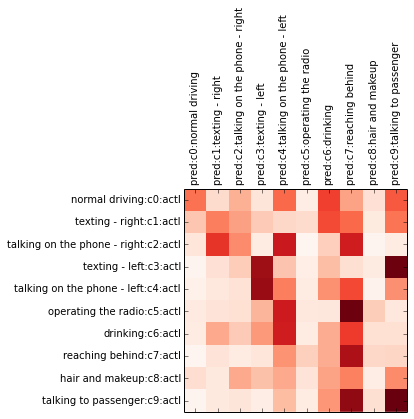

  predicting 79726 new obs...

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 8786, 11144, 10374,  6453,  5874,  4904,  9130,  6548,  7613,  8900]))}
  duration: 19 seconds


In [30]:
lr1MdlDf, lr1YVldPby, lr1YNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 1000, nStepsTfw = 100, lrnRateTfw = 0.1, 
    visualize = False, newObs = True, verbose = True)


Logistic Regression (TensorFlow): nObsFit: 1000; nStepsTfw:  100; lrnRateTfw:0.5000
  visualize: False; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

  Fit accuracy:0.4970
  Fit  logLoss:5.6870

  Vld accuracy:0.2227
  Vld  logLoss:13.3804
[[148  76  77   0  65   0   4  41   4  69]
 [ 58  87 100   0  44   4   2 121   9  53]
 [ 11  63 120   0 110   0   0 121   0  27]
 [ 10  36  83   1 132   3   3  31   0 144]
 [ 11  19  86   0 197   5  17  53   0  71]
 [ 34   7  66   0  79  35   1 121  38  41]
 [ 33  35 135   0 134   2   1  73   5  25]
 [  2  15  39   0  46  10   0 191  22  25]
 [ 30  24 105   0  40   6   0  62  32  65]
 [ 13  12  87   0  47   6   0 128   3 156]]


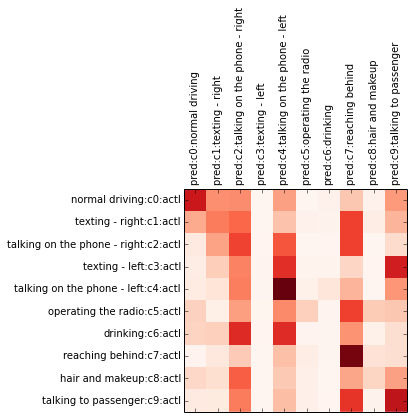

  predicting 79726 new obs...

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([12150, 13070, 22283,   135,  4653,  4845,   390,  7545,  5352,  9303]))}
  duration: 19 seconds


In [31]:
lr5MdlDf, lr5YVldPby, lr5YNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 1000, nStepsTfw = 100, lrnRateTfw = 0.5, 
    visualize = False, newObs = True, verbose = True)

In [108]:
%run img_utils.py
from sklearn import metrics as skl_metrics    

def lclaccuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == 
                           np.argmax(labels, 1))
              / predictions.shape[0])
    
print "\nlrnRateTfw: 0.1; accVld: %0.4f" % \
    (lclaccuracy_score(lr1YVldPby, glbYVld))
cnf1YVld = skl_metrics.confusion_matrix(glbObsVldRsp, 
                                        np.argmax(lr1YVldPby, 1))
print cnf1YVld
# print cnf1YVld.sum(axis = 1)
print cnf1YVld.diagonal() * 1.0 / cnf1YVld.sum(axis = 1)
# print cnf1YVld.sum(axis = 1).sum()

lls1YVld = skl_metrics.log_loss(glbYVld, lr1YVldPby)
print "\nlrnRateTfw: 0.1; logLossVld: %0.4f" % (lls1YVld)
# lls1YVldCls = np.array([skl_metrics.log_loss(
#                glbYVld[glbYVld[:, clsIx] == 1, :], 
#             lr1YVldPby[glbYVld[:, clsIx] == 1, :]) \
#                      for clsIx in range(glbRspClassN)]) / glbRspClassN
# print "lrnRateTfw: 0.1; logLossVld.skl classSum: %0.4f" % (lls1YVld.sum())
# print lls1YVld
lls1YVldCls = mygetMetricLogLoss(glbYVld, lr1YVldPby, returnTyp = 'class')
print "lrnRateTfw: 0.1; logLossVldCls :"; print lls1YVldCls
# print "diff: %.4e" % (np.abs(lls1YVld - lls1YVldCls.sum()))
assert np.abs(lls1YVld - lls1YVldCls.sum()) < 1e-04, \
    "logLoss from skl: %.4f vs myCls %.4f does not match" % \
    (lls1YVld, lls1YVldCls.sum())
    
print "\nlrnRateTfw: 0.5; accVld: %0.4f" % \
    (lclaccuracy_score(lr5YVldPby, glbYVld))
cnf5YVld = skl_metrics.confusion_matrix(glbObsVldRsp, 
                                        np.argmax(lr5YVldPby, 1))
print cnf5YVld
print cnf5YVld.diagonal() * 1.0 / cnf5YVld.sum(axis = 1)

lls5YVld = skl_metrics.log_loss(glbYVld, lr5YVldPby)
print "\nlrnRateTfw: 0.5; logLossVld: %0.4f" % (lls5YVld)
lls5YVldCls = mygetMetricLogLoss(glbYVld, lr5YVldPby, returnTyp = 'class')
print "lrnRateTfw: 0.5; logLossVldCls :"; print lls5YVldCls
assert np.abs(lls5YVld - lls5YVldCls.sum()) < 1e-04, \
    "logLoss from skl: %.4f vs myCls %.4f does not match" % \
    (lls5YVld, lls5YVldCls.sum())


lrnRateTfw: 0.1; accVld: 0.1735
[[ 73  22  44  15  77   7  94  50  18  84]
 [ 33  68  51  31  24  22  90  77  10  72]
 [ 14 100  61   9 115   1  28 113   2   9]
 [  2  18  29 136  34   7  37  19  10 151]
 [  5  14  17 137  67   9  58  91   3  58]
 [ 11  16  19  41 114  13  14 151  30  13]
 [  9  47  31  55 113   9  45  96  19  19]
 [  1  16  10  14  57  28  45 130  24  25]
 [ 21  12  47  36  47  16  50  66   8  61]
 [  2  12  15   8  38   9  56 140  19 153]]
[ 0.1508  0.1423  0.135   0.307   0.146   0.0308  0.1016  0.3714  0.022
  0.3385]

lrnRateTfw: 0.1; logLossVld: 12.6001
lrnRateTfw: 0.1; logLossVldCls :
[ 1.4741  2.0839  1.4873  0.8025  1.0307  1.8989  1.0157  0.5303  1.2532
  1.0236]

lrnRateTfw: 0.5; accVld: 0.2227
[[148  76  77   0  65   0   4  41   4  69]
 [ 58  87 100   0  44   4   2 121   9  53]
 [ 11  63 120   0 110   0   0 121   0  27]
 [ 10  36  83   1 132   3   3  31   0 144]
 [ 11  19  86   0 197   5  17  53   0  71]
 [ 34   7  66   0  79  35   1 121  38  41]
 [ 33  35

In [10]:
# glbMdlDf = None
# glbMdlDf = pd.DataFrame()

try:
    with open(glbPickleFile['models'], 'rb') as f:
        glbMdlDf = pickle.load(f)
        assert isinstance(glbMdlDf, pd.DataFrame), \
            'type(glbMdlDf): %s, expecting pd.DataFrame' % \
            (str(type(glbMdlDf)))            
except IOError, e:
    print e
    print 'file %s not present or not appropriate' % \
        (glbPickleFile['models'])        
print glbMdlDf         

                                           accVld  \
id         nStepsTfw nObsFit lrnRateTfw             
LgtRgr.skl -1.0      22424.0 -1.0        1.000000   
LgtRgr.tfw  1000.0   18077.0  10.0       0.375201   
LgtRgr.skl -1.0      18077.0 -1.0        0.343685   
LgtRgr.tfw  1000.0   18077.0  1.0        0.320221   
LgtRgr.skl -1.0      15000.0 -1.0        0.342535   
LgtRgr.tfw  1000.0   10000.0  10.0       0.384173   
LgtRgr.skl -1.0      10000.0 -1.0        0.358638   
LgtRgr.tfw  1000.0   10000.0  1.0        0.319991   
                              0.1        0.251208   
LgtRgr.skl -1.0      5000.0  -1.0        0.363699   
                     2000.0  -1.0        0.341385   
                     1000.0  -1.0        0.333333   
LgtRgr.tfw  100.0    1000.0   10.0       0.273522   
                              1.0        0.255809   
                              0.1        0.173453   
LgtRgr.skl -1.0      100.0   -1.0        0.307108   

                                             

In [12]:
%run img_utils.py
srchParamsDct = {
    'nObsFit' : [glbObsTrnFtr.shape[0]],
#     'nObsFit' : [100, 1000, 5000, 10000, glbObsFitFtr.shape[0]]
    'nStepsTfw' : [1000],
#     'nStepsTfw' : [1000, 2000],    
    'lrnRateTfw' : [1.0, 10.0]
#     'lrnRateTfw' : [0.1, 1.0, 10.0]    
                }

jnk = mysearchParams(fitMdlLgtRgrTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'displayonly', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , True    , False,        False],
                save_drop_cols = 'model',     
                save_filepathname = glbPickleFile['models'],
              lclXFit = glbXFit, lclYFit = glbYFit) 

# thsDf, thsObsVldRspPredProba, thsObsNewRspPredProba = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = False, newObs = False, verbose = False)

NameError: name 'glbXFit' is not defined

In [14]:
%run img_utils.py

glbMdlDf = mysearchParams(fitMdlLgtRgrTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'run', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , False    , True,        True],       
                save_filepathname = glbPickleFile['models'],
                save_drop_cols = 'model',          
              lclXFit = glbXFit, lclYFit = glbYFit)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


mysearchParams: running <function fitMdlLgtRgrTfw at 0x11994eed8> with params:
nStepsTfw      1000.0
nObsFit       18077.0
lrnRateTfw        1.0
Name: (-1.0, 100.0, -1.0), dtype: float64

Logistic Regression (TensorFlow): nObsFit:18077; nStepsTfw: 1000; lrnRateTfw:1.0000
  visualize: False; newObs: False; verbose: False
  logLoss at step   200: 3.8964 (109 secs)
  logLoss at step   400: 0.4543 (211 secs)
  logLoss at step   600: 0.2883 (313 secs)
  logLoss at step   800: 0.2021 (415 secs)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:122: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:124: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



  duration: 519 seconds
                                                                                 accVldCls  \
id         nStepsTfw nObsFit lrnRateTfw                                                      
LgtRgr.skl -1.0      22424.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  10.0       {u'accCls': [0.504132231405, 0.435146443515, 0...   
LgtRgr.skl -1.0      18077.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  1.0        {u'accCls': [0.326446280992, 0.209205020921, 0...   
LgtRgr.skl -1.0      15000.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   10000.0  10.0       {u'accCls': [0.456611570248, 0.380753138075, 0...   
LgtRgr.skl -1.0      10000.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   10000.0  1.0        {u'accCls': [0.289256198347, 0.182008368201, 0...   
                              0.1  

In [16]:
lrn10Srs = glbMdlDf.ix[('LgtRgr.tfw',  1000.0,   18077.0,  10.0)]
# print lrn10Srs
lrn01Srs = glbMdlDf.ix[('LgtRgr.tfw',  1000.0,   18077.0,   1.0)]
# print lrn01Srs

print "lrn10Srs: accVld: %.4f" % (lrn10Srs['accVld'])
print "lrn01Srs: accVld: %.4f" % (lrn01Srs['accVld'])
print "lrn10-01: accVldDff: %.4f" % (lrn10Srs['accVld'] - lrn01Srs['accVld'])

print "lrn10Srs: accVldCls:"; print (lrn10Srs['accVldCls']['accCls'])
print "lrn01Srs: accVldCls:"; print (lrn01Srs['accVldCls']['accCls'])
print "lrn10-01: accVldClsDff:"; print (lrn10Srs['accVldCls']['accCls'] - 
                                        lrn01Srs['accVldCls']['accCls'])

print "\n"
print "lrn10Srs: logLossVld: %8.4f" % (lrn10Srs['logLossVld'])
print "lrn01Srs: logLossVld: %8.4f" % (lrn01Srs['logLossVld'])
print "lrn10-01: logLossVldDff: %8.4f" % (lrn10Srs['logLossVld'] - 
                                          lrn01Srs['logLossVld'])

print "lrn10Srs: logLossVldCls:"; print (lrn10Srs['logLossVldCls']['logLossCls'])
print "lrn01Srs: logLossVldCls:"; print (lrn01Srs['logLossVldCls']['logLossCls'])
print "lrn10-01: logLossVldClsDff:"; 
print (lrn10Srs['logLossVldCls']['logLossCls'] - 
       lrn01Srs['logLossVldCls']['logLossCls'])

lrn10Srs: accVld: 0.3752
lrn01Srs: accVld: 0.3202
lrn10-01: accVldDff: 0.0550
lrn10Srs: accVldCls:
[ 0.5041  0.4351  0.3805  0.1738  0.3965  0.2464  0.6749  0.5143  0.25
  0.1637]
lrn01Srs: accVldCls:
[ 0.3264  0.2092  0.2323  0.2144  0.3878  0.1588  0.6637  0.6286  0.2088
  0.219 ]
lrn10-01: accVldClsDff:
[ 0.1777  0.2259  0.1482 -0.0406  0.0087  0.0877  0.0113 -0.1143  0.0412
 -0.0553]


lrn10Srs: logLossVld:  19.2099
lrn01Srs: logLossVld:   9.4750
lrn10-01: logLossVldDff:   9.7349
lrn10Srs: logLossVldCls:
[ 1.726   1.7854  1.8043  2.6157  1.9122  2.3841  0.9763  1.0939  1.9704
  2.9416]
lrn01Srs: logLossVldCls:
[ 1.0565  1.4437  0.9226  1.0162  0.8034  1.5807  0.2146  0.2664  0.879
  1.2919]
lrn10-01: logLossVldClsDff:
[ 0.6695  0.3417  0.8817  1.5995  1.1088  0.8034  0.7616  0.8275  1.0915
  1.6497]


In [158]:
# Set value based on condition

# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']
# glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id'] = 'LgtRgr.SGD.tf'
# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']

def lclfixNanDf(df, column, default):
    print df[column].isnull()
    df.ix[df[column].isnull(), column] = default
    return(df)

# col = 'lrnRateTfw'; default = -1.0; 
# tmpMdlDf = lclfixNanDf(glbMdlDf, col, default); print tmpMdlDf[col]

# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]
# glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), 'id'] = 'LogisticRegression.tf'
# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]

# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]
# # glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsBtc'] = \
# #     glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsFit']
# glbMdlDf['nObsBtc'] = glbMdlDf.apply(
#     lambda (row): row['nObsFit'] if pd.isnull(row['nObsBtc']) else row['nObsBtc'],
#                         axis = 1)
# print 'After:'    
# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]

# Change value
# tmpMdlDf = glbMdlDf
# print tmpMdlDf[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                (tmpMdlDf['nStepsTfw'] == 1.0)]
# print tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw']
# tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw'] = -1.0
# print 'After:'
# print tmpMdlDf

# Remove specific models
mask = (glbMdlDf['id'].str.contains('LgtRgr.tfw', na = False))
# mask = (glbMdlDf['id'].str.contains('LgtRgr.tfw', na = False)) & \
#        (glbMdlDf['nObsFit'] == 10000.0)
print mask
tmpMdlDf = glbMdlDf[~mask]
# print tmpMdlDf

# Remove dups
# print glbMdlDf.columns
# print (glbMdlDf['logLossVld'])
# print (glbMdlDf.index.duplicated())
# tmpMdlDf = glbMdlDf[~glbMdlDf.index.duplicated()]
# print (tmpMdlDf.index.duplicated())

glbMdlDf = tmpMdlDf
print 'After:'
print glbMdlDf

id          nStepsTfw  nObsFit  lrnRateTfw
LgtRgr.skl  -1.0       22424.0  -1.0          False
                       18077.0  -1.0          False
                       15000.0  -1.0          False
LgtRgr.tfw   1000.0    10000.0   10.0          True
LgtRgr.skl  -1.0       10000.0  -1.0          False
LgtRgr.tfw   1000.0    10000.0   1.0           True
                                 0.5           True
LgtRgr.skl  -1.0       5000.0   -1.0          False
                       2000.0   -1.0          False
                       1000.0   -1.0          False
LgtRgr.tfw   100.0     1000.0    10.0          True
                                 1.0           True
                                 0.5           True
LgtRgr.skl  -1.0       100.0    -1.0          False
Name: id, dtype: bool
After:
                                           accVld accVldCls bestFit  duration  \
id         nStepsTfw nObsFit lrnRateTfw                                         
LgtRgr.skl -1.0      22424.0 -1.0     

In [26]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

labels ['model'] not contained in axis
Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 3 KB


In [14]:
glbMdlDf['bestFit'] = False
glbMdlDf.ix[('LgtRgr.tfw', 1000.0, 18077.0, 10.0), 'bestFit'] = True
# LgtRgr.tfw  1000.0   18077.0  10.0
print glbMdlDf[list(set(glbMdlDf.columns) - set(srchParamsDct.keys()))]
# print glbMdlDf[glbMdlDf.nObsFit >= 10000][
#     list(set(glbMdlDf.columns) - set(srchParamsDct.keys()))]

                                                                                 accVldCls  \
id         nStepsTfw nObsFit lrnRateTfw                                                      
LgtRgr.skl -1.0      22424.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  10.0       {u'accCls': [0.504132231405, 0.435146443515, 0...   
LgtRgr.skl -1.0      18077.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  1.0        {u'accCls': [0.326446280992, 0.209205020921, 0...   
LgtRgr.skl -1.0      15000.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   10000.0  10.0       {u'accCls': [0.456611570248, 0.380753138075, 0...   
LgtRgr.skl -1.0      10000.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   10000.0  1.0        {u'accCls': [0.289256198347, 0.182008368201, 0...   
                              0.1        {u'accCls': [0.1694

/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py:212: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


In [4]:
# # With gradient descent training, even this much data is prohibitive.
# # Subset the training data for faster turnaround.
# nObsFit = 10000

# graph = tf.Graph()
# with graph.as_default():

#   # Input data.
#   # Load the training, validation and test data into constants that are
#   # attached to the graph.
#   tfwObsFitFtr = tf.constant(glbXFit[:nObsFit, :])
#   tfwObsFitRsp = tf.constant(glbYFit[:nObsFit])
#   tfwObsVldFtr = tf.constant(glbXVld)
#   tfwObsNewFtr = tf.constant(glbXNew)
  
#   # Variables.
#   # These are the parameters that we are going to be training. The weight
#   # matrix will be initialized using random valued following a (truncated)
#   # normal distribution. The tfwB get initialized to zero.
#   tfwW = tf.Variable(
#     tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]), name = 'tfwW')
#   tfwB = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB')
#   print(tfwW.initialized_value())
#   print(tfwB.initialized_value())
# #   print 'initial  tfwB:%s' % (np.vectorize("%.4e".__mod__)(tf.get_variable('tfwB')))
# #   print 'initial tfwW (first 5 only):' 
# #   for lblIx in xrange(glbRspClassN):
# #     print 'lblIx:%2d:%s'% (np.vectorize("%.4e".__mod__)(tfwW.value()[:5, lblIx]))
  
#   # Training computation.
#   # We multiply the inputs with the weight matrix, and add tfwB. We compute
#   # the softmax and cross-entropy (it's one operation in TensorFlow, because
#   # it's very common, and it can be optimized). We take the average of this
#   # cross-entropy across all training examples: that's our loss.
#   logits = tf.matmul(tfwObsFitFtr, tfwW) + tfwB
#   loss = tf.reduce_mean(
#     tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))
  
#   # Optimizer.
#   # We are going to find the minimum of this loss using gradient descent.
#   optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
#   # Predictions for the training, validation, and test data.
#   # These are not part of training, but merely here so that we can report
#   # accuracy_score figures as we train.
#   tfwObsTrnPred = tf.nn.softmax(logits)
#   tfwObsVldPred = tf.nn.softmax(
#     tf.matmul(tfwObsVldFtr, tfwW) + tfwB)
#   tfwObsNewPred = tf.nn.softmax(tf.matmul(tfwObsNewFtr, tfwW) + tfwB)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run this computation and iterate:

In [58]:
# nStepsTfw = 801

# def accuracy_score(predictions, labels):
#   return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
#           / predictions.shape[0])

# with tf.Session(graph=graph) as session:
#   # This is a one-time operation which ensures the parameters get initialized as
#   # we described in the graph: random tfwW for the matrix, zeros for the
#   # tfwB. 
#   tf.initialize_all_variables().run()
#   print('Initialized')
#   for step in range(nStepsTfw):
#     # Run the computations. We tell .run() that we want to run the optimizer,
#     # and get the loss value and the training predictions returned as numpy
#     # arrays.
#     _, l, predictions = session.run([optimizer, loss, tfwObsTrnPred])
#     if (step % 100 == 0):
#       print('Loss at step %d: %f' % (step, l))
#       print('Training accuracy_score: %.1f%%' % accuracy_score(
#         predictions, glbYFit[:nObsFit, :]))
#       # Calling .eval() on tfwObsVldPred is basically like calling run(), but
#       # just to get that one numpy array. Note that it recomputes all its graph
#       # dependencies.
#       print('Validation accuracy_score: %.1f%%' % accuracy_score(
#         tfwObsVldPred.eval(), glbYVld))
#   print('Test accuracy_score: %.1f%%' % accuracy_score(tfwObsNewPred.eval(), glbYNew))

In [22]:
robjects.pandas2ri.activate()
pltRDf = robjects.conversion.py2ri(glbMdlDf)
# print(pltRDf)
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld', 'duration'), 
            dim = c('nObsFit', 'id', 'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_03_fit_lgtRgr_Tfw_SFDD_glbMdlDf.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsFit', 'id', 'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_03_fit_lgtRgr_Tfw_SFDD_glbMdlDf_logLossVld.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld'), 
            dim = c('nObsFit', 'id', 'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_03_fit_lgtRgr_Tfw_SFDD_glbMdlDf_accVld.png')

<ListVector - Python:0x144af9098 / R:0x7ffce67838a8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x144af9098 / R:0x7ffce67838a8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x144af9098 / R:0x7ffce67838a8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x144abac68 / R:0x7ffcd4279898>
  ...
<ListVector - Python:0x144af9098 / R:0x7ffce67838a8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x144adaef0 / R:0x7ffcd40465b8>
<ListVector - Python:0x144af9098 / R:0x7ffce67838a8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [21]:
glbMdlDf.to_csv('img_03_fit_lgtRgr_Tfw_SFDD_glbMdlDf.csv')

### Fit selected model to glbObsFit

In [15]:
selMdlSrs = glbMdlDf[glbMdlDf['bestFit']]
print selMdlSrs

                                           accVld  \
id         nStepsTfw nObsFit lrnRateTfw             
LgtRgr.tfw 1000.0    18077.0 10.0        0.375201   

                                                                                 accVldCls  \
id         nStepsTfw nObsFit lrnRateTfw                                                      
LgtRgr.tfw 1000.0    18077.0 10.0        {u'accCls': [0.504132231405, 0.435146443515, 0...   

                                        bestFit  duration          id  \
id         nStepsTfw nObsFit lrnRateTfw                                 
LgtRgr.tfw 1000.0    18077.0 10.0          True       519  LgtRgr.tfw   

                                         logLossVld  \
id         nStepsTfw nObsFit lrnRateTfw               
LgtRgr.tfw 1000.0    18077.0 10.0         19.209913   

                                                                             logLossVldCls  \
id         nStepsTfw nObsFit lrnRateTfw                                      


Logistic Regression (TensorFlow): nObsFit:18077; nStepsTfw: 1000; lrnRateTfw:10.0000
  visualize: True; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized
  logLoss at step   200: 44.2288 (106 secs)
  logLoss at step   400: 1.1421 (206 secs)
  logLoss at step   600: 0.5688 (306 secs)
  logLoss at step   800: 0.3106 (405 secs)

  Fit accuracy:0.9914
  Fit  logLoss:0.1189

  Vld accuracy:0.3752
[ 0.5041  0.4351  0.3805  0.1738  0.3965  0.2464  0.6749  0.5143  0.25
  0.1637]
[[244  21  36   2  98   0  23  47   5   8]
 [  4 208   9   0   2   0   4 241   6   4]
 [  0   2 172   0   0   1 147 120   9   1]
 [  3   2  79  77 183  41   2   0  39  17]
 [ 24   3  56  42 182  31  15  33  37  36]
 [ 15   9   7   0  44 104 218   4  21   0]
 [  1  16  25   3   6   0 299  78  13   2]
 [  0   8  15   0   0   0  81 180  66   0]
 [  7   7  53  15   5   0 138  46  91   2]
 [ 13   0

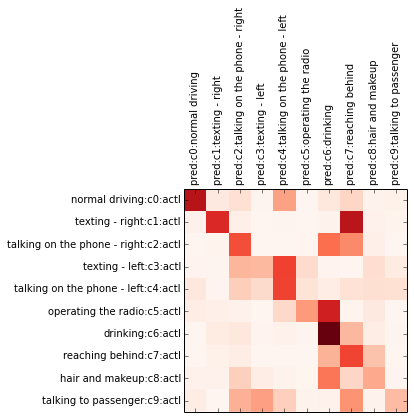


  Vld  logLoss:19.2099
[ 1.726   1.7854  1.8043  2.6157  1.9122  2.3841  0.9763  1.0939  1.9704
  2.9416]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 227
  img_62023.jpg:
  plot_occlusion:


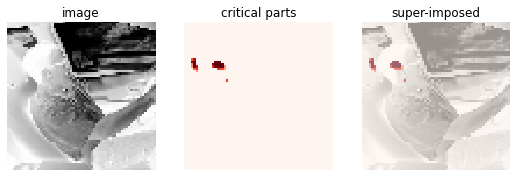

  display_weight:


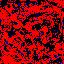

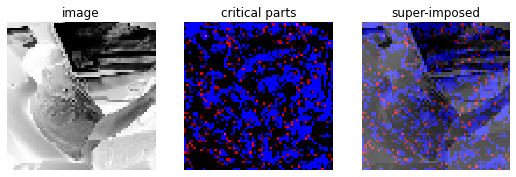

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.5098; nObs: 1
  img_49323.jpg:
  plot_occlusion:


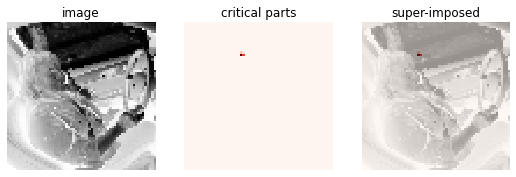

  display_weight:


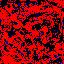

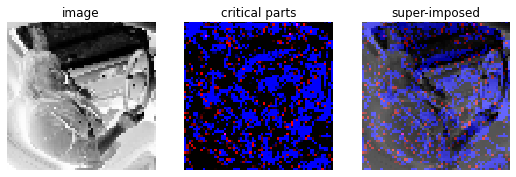

  Proba:
[ 0.5098  0.      0.      0.      0.      0.      0.4321  0.0581  0.      0.    ]
  next best class: drinking


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 197
  img_53130.jpg:
  plot_occlusion:


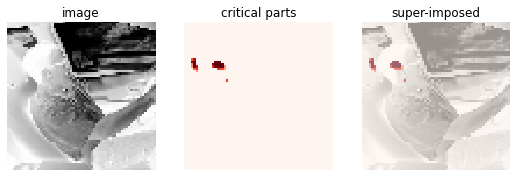

  display_weight:


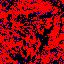

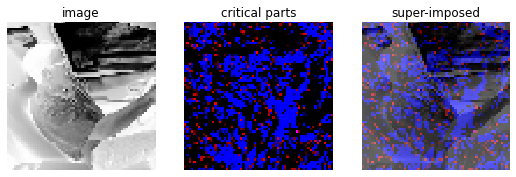

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4848; nObs: 1
  img_42578.jpg:
  plot_occlusion:


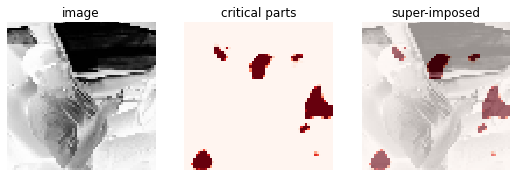

  display_weight:


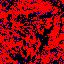

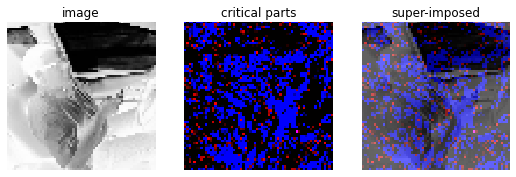

  Proba:
[ 0.3915  0.4848  0.      0.      0.      0.      0.1237  0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 405
  img_79556.jpg:
  plot_occlusion:


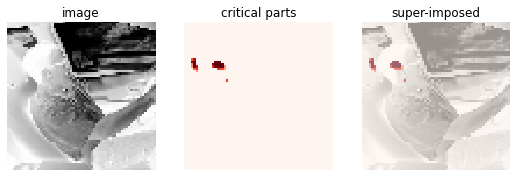

  display_weight:


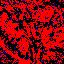

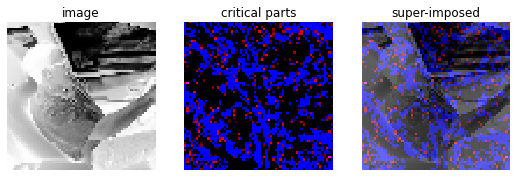

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.3804; nObs: 1
  img_68054.jpg:
  plot_occlusion:


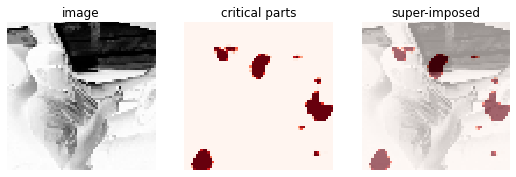

  display_weight:


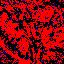

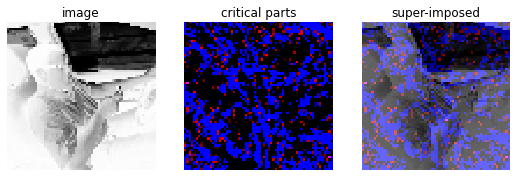

  Proba:
[ 0.      0.      0.3804  0.      0.336   0.      0.      0.2835  0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 203
  img_79904.jpg:
  plot_occlusion:


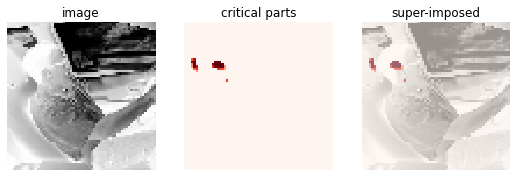

  display_weight:


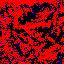

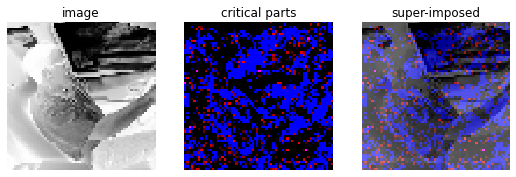

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.8969; nObs: 1
  img_1106.jpg:
  plot_occlusion:


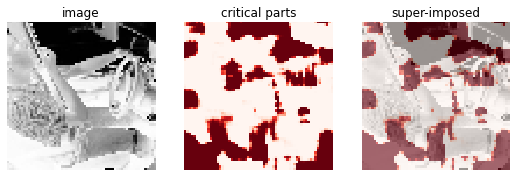

  display_weight:


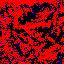

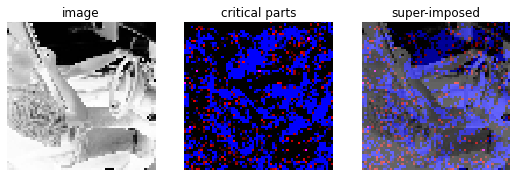

  Proba:
[ 0.0936  0.      0.      0.8969  0.      0.      0.0095  0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 467
  img_18343.jpg:
  plot_occlusion:


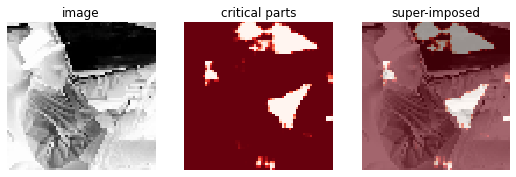

  display_weight:


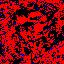

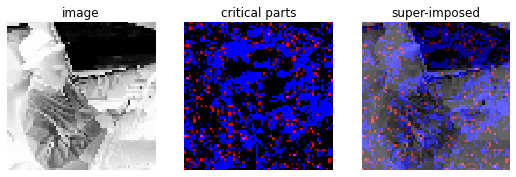

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.5164; nObs: 1
  img_35848.jpg:
  plot_occlusion:


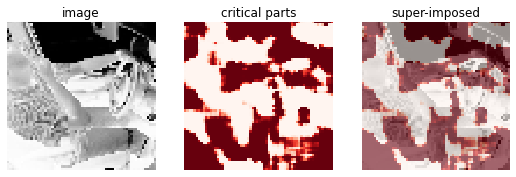

  display_weight:


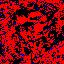

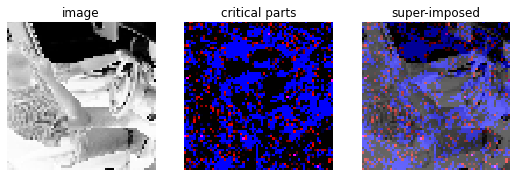

  Proba:
[ 0.      0.      0.      0.      0.5164  0.      0.      0.      0.
  0.4836]
  next best class: talking to passenger


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 134
  img_15928.jpg:
  plot_occlusion:


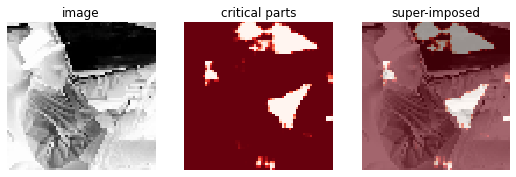

  display_weight:


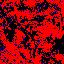

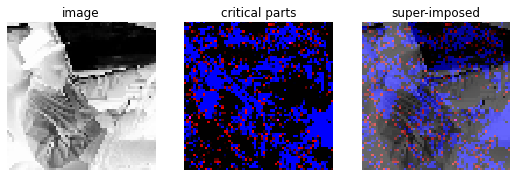

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5088; nObs: 1
  img_73704.jpg:
  plot_occlusion:


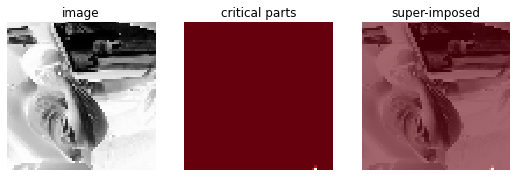

  display_weight:


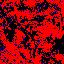

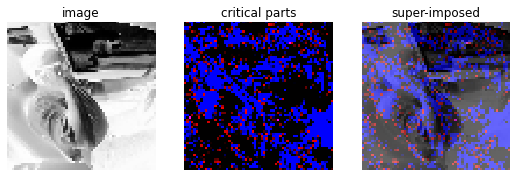

  Proba:
[ 0.      0.      0.      0.      0.      0.5088  0.      0.      0.4912
  0.    ]
  next best class: hair and makeup


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 748
  img_29251.jpg:
  plot_occlusion:


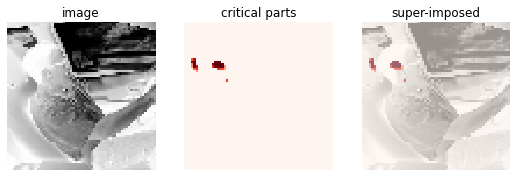

  display_weight:


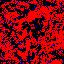

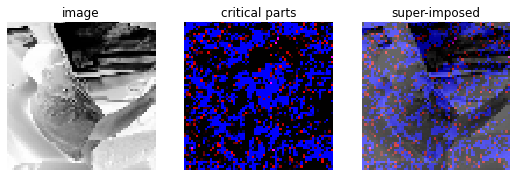

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.4823; nObs: 1
  img_61731.jpg:
  plot_occlusion:


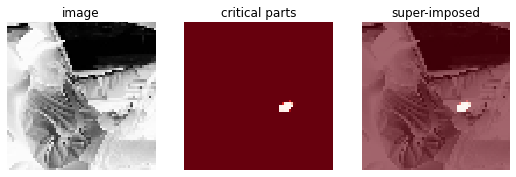

  display_weight:


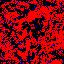

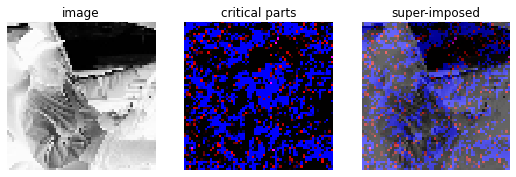

  Proba:
[ 0.      0.      0.0358  0.      0.      0.      0.4823  0.4819  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 646
  img_89322.jpg:
  plot_occlusion:


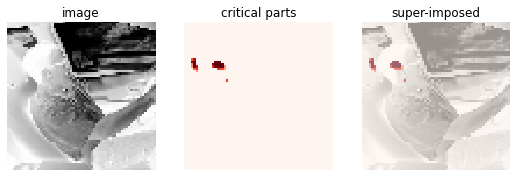

  display_weight:


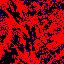

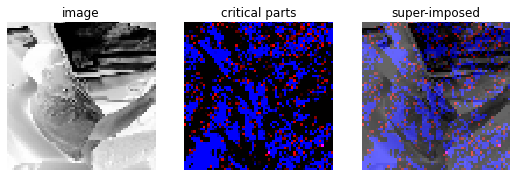

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.5852; nObs: 1
  img_57279.jpg:
  plot_occlusion:


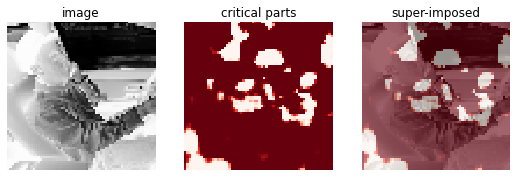

  display_weight:


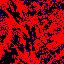

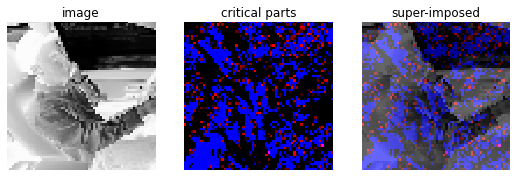

  Proba:
[ 0.      0.      0.4148  0.      0.      0.      0.      0.5852  0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 205
  img_31586.jpg:
  plot_occlusion:


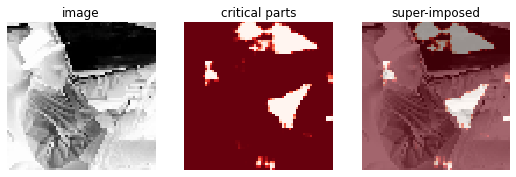

  display_weight:


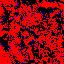

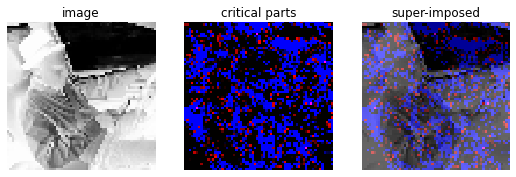

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.5303; nObs: 1
  img_50218.jpg:
  plot_occlusion:


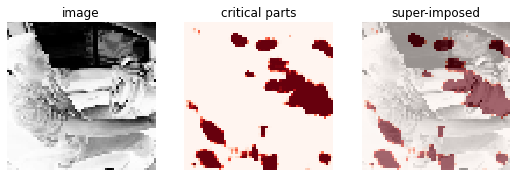

  display_weight:


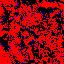

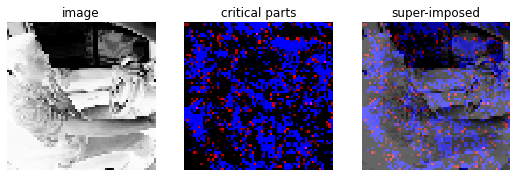

  Proba:
[ 0.4548  0.      0.      0.      0.      0.      0.015   0.      0.5303
  0.    ]
  next best class: normal driving


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 85
  img_35236.jpg:
  plot_occlusion:


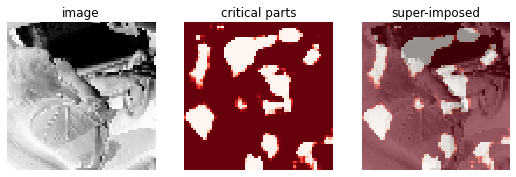

  display_weight:


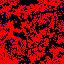

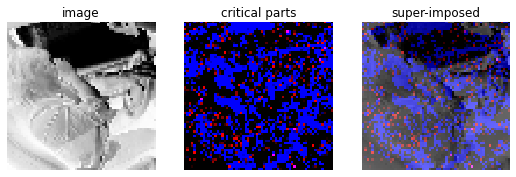

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.5486; nObs: 1
  img_33399.jpg:
  plot_occlusion:


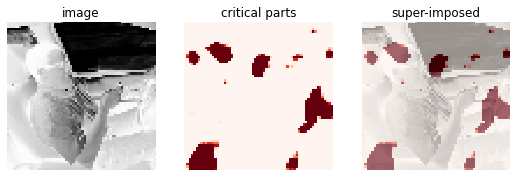

  display_weight:


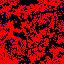

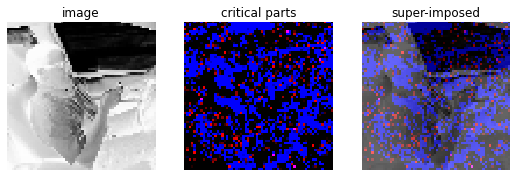

  Proba:
[ 0.      0.      0.      0.      0.4514  0.      0.      0.      0.
  0.5486]
  next best class: talking on the phone - left
  predicting 79726 new obs...
    @  551 secs: obsIx:     0
    @  552 secs: obsIx:  8000
    @  557 secs: obsIx: 40000


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 4137
  img_100.jpg:
  plot_occlusion:


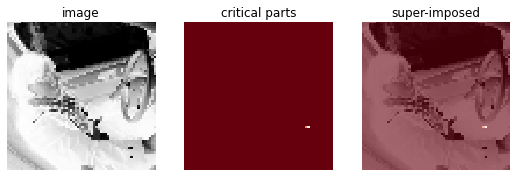

  display_weight:


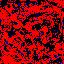

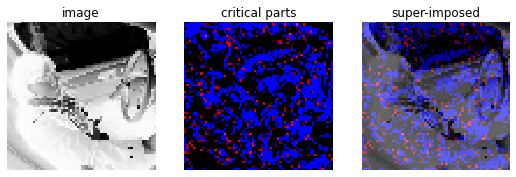

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.4154; nObs: 1
  img_93716.jpg:
  plot_occlusion:


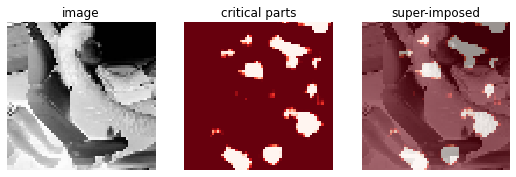

  display_weight:


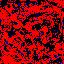

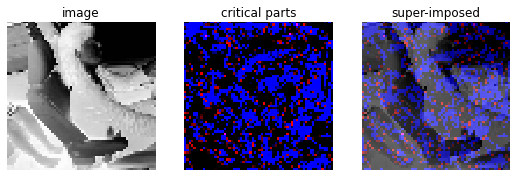

  Proba:
[ 0.4154  0.      0.      0.      0.      0.      0.      0.      0.3153
  0.2693]
  next best class: hair and makeup


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 4845
  img_100001.jpg:
  plot_occlusion:


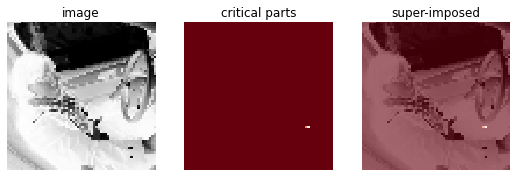

  display_weight:


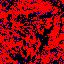

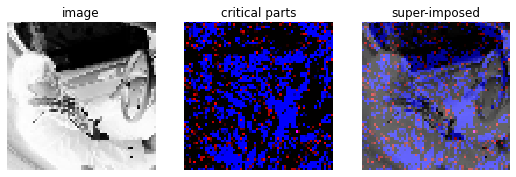

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4962; nObs: 1
  img_74063.jpg:
  plot_occlusion:


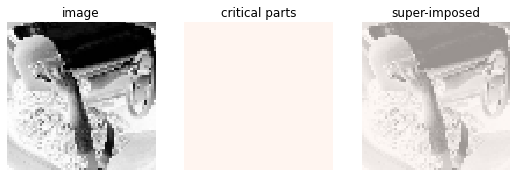

  display_weight:


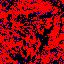

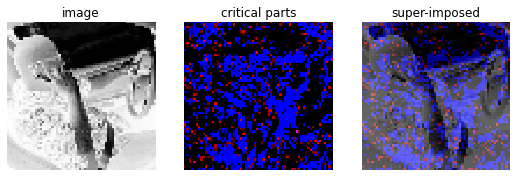

  Proba:
[ 0.      0.4962  0.      0.      0.      0.      0.4737  0.      0.0302
  0.    ]
  next best class: drinking


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 10247
  img_1.jpg:
  plot_occlusion:


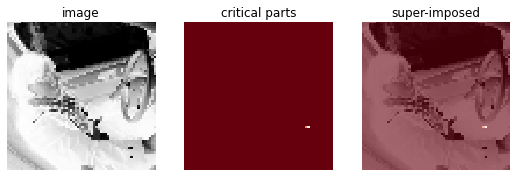

  display_weight:


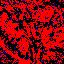

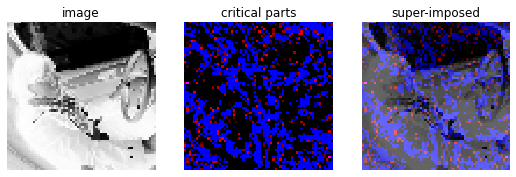

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.4067; nObs: 1
  img_79284.jpg:
  plot_occlusion:


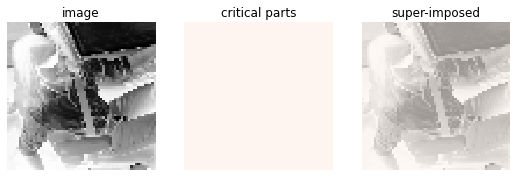

  display_weight:


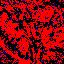

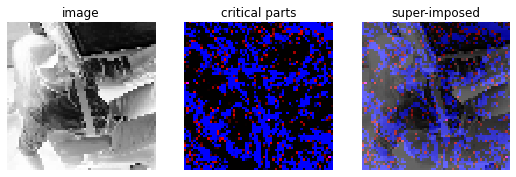

  Proba:
[ 0.194   0.      0.4067  0.      0.      0.3993  0.      0.      0.      0.    ]
  next best class: operating the radio


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 4237
  img_100011.jpg:
  plot_occlusion:


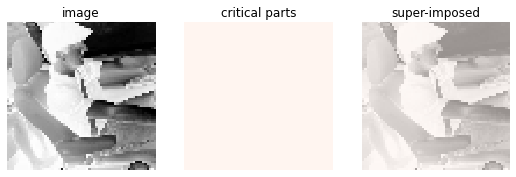

  display_weight:


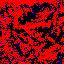

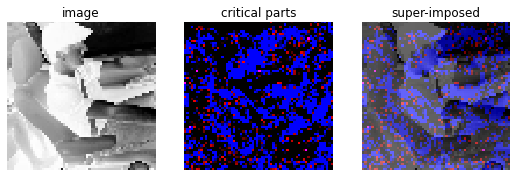

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.4187; nObs: 1
  img_25992.jpg:
  plot_occlusion:


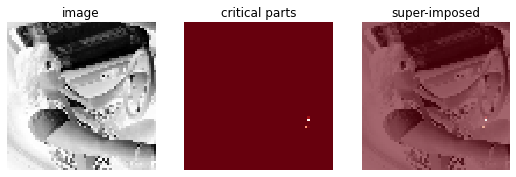

  display_weight:


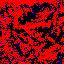

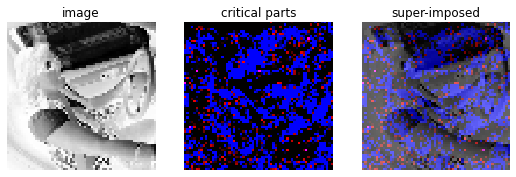

  Proba:
[ 0.      0.      0.      0.4187  0.      0.3735  0.2078  0.      0.      0.    ]
  next best class: operating the radio


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 4865
  img_100002.jpg:
  plot_occlusion:


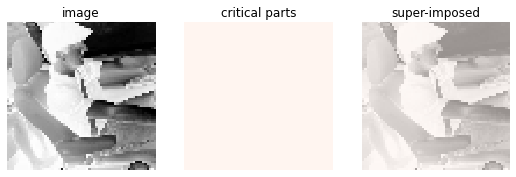

  display_weight:


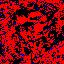

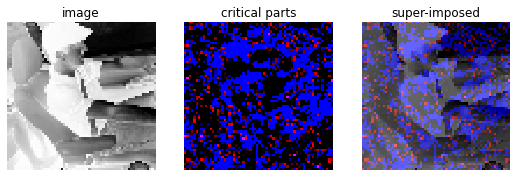

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.3965; nObs: 1
  img_74899.jpg:
  plot_occlusion:


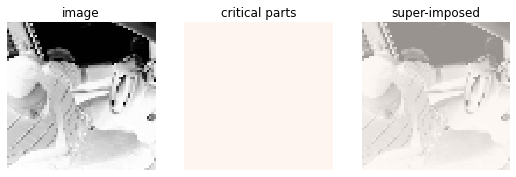

  display_weight:


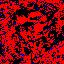

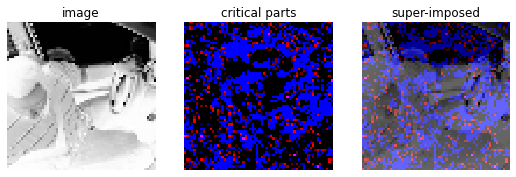

  Proba:
[ 0.      0.      0.      0.      0.3965  0.      0.      0.      0.2966
  0.3068]
  next best class: talking to passenger


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 4766
  img_100023.jpg:
  plot_occlusion:


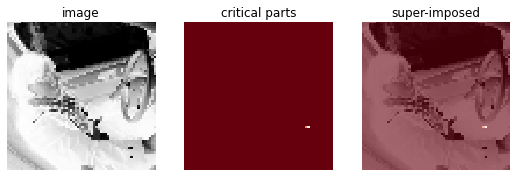

  display_weight:


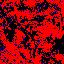

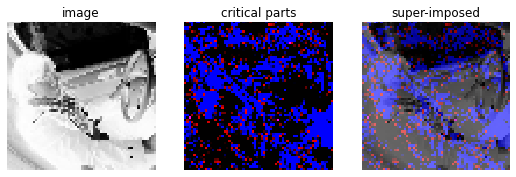

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5008; nObs: 1
  img_10497.jpg:
  plot_occlusion:


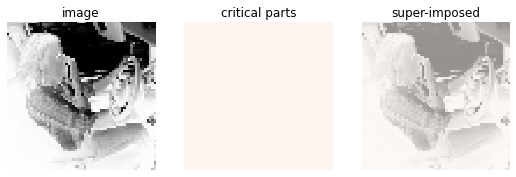

  display_weight:


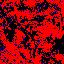

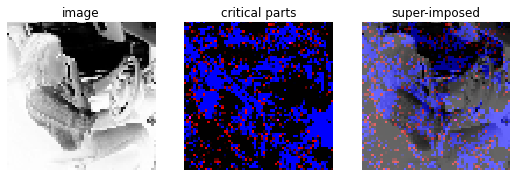

  Proba:
[ 0.4992  0.      0.      0.      0.      0.5008  0.      0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 4439
  img_100004.jpg:
  plot_occlusion:


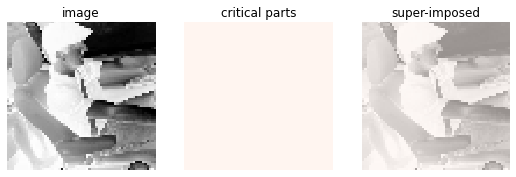

  display_weight:


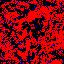

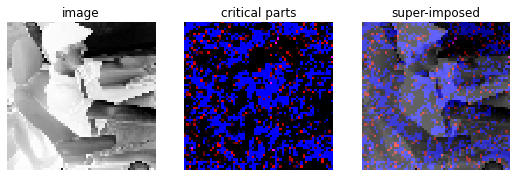

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.4996; nObs: 1
  img_70494.jpg:
  plot_occlusion:


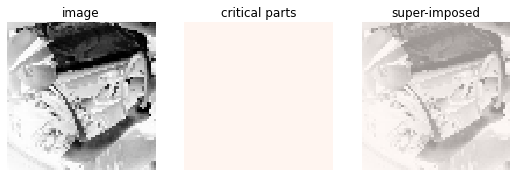

  display_weight:


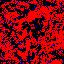

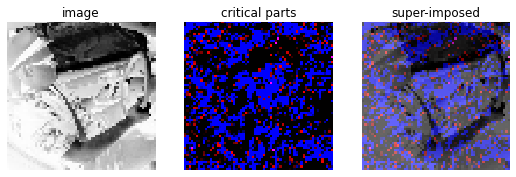

  Proba:
[ 0.      0.0041  0.      0.      0.      0.      0.4996  0.      0.4963
  0.    ]
  next best class: hair and makeup


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 8032
  img_100005.jpg:
  plot_occlusion:


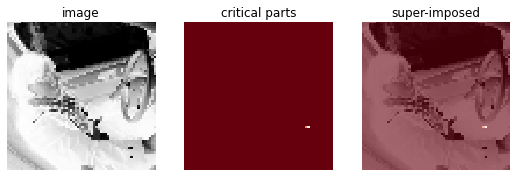

  display_weight:


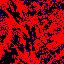

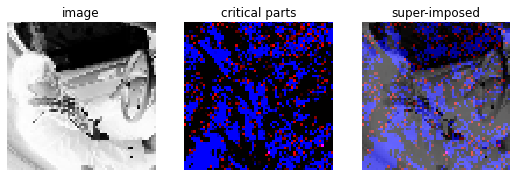

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4066; nObs: 1
  img_37771.jpg:
  plot_occlusion:


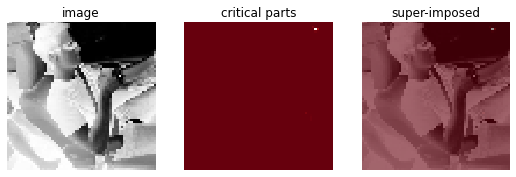

  display_weight:


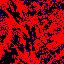

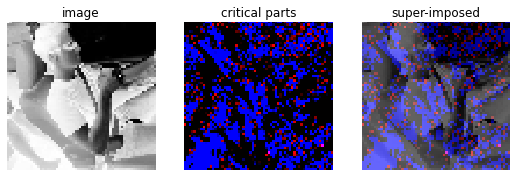

  Proba:
[ 0.      0.      0.3606  0.      0.      0.      0.      0.4066  0.2328
  0.    ]
  next best class: talking on the phone - right


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 9435
  img_100007.jpg:
  plot_occlusion:


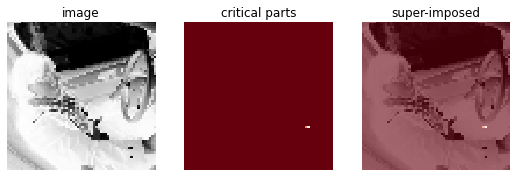

  display_weight:


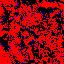

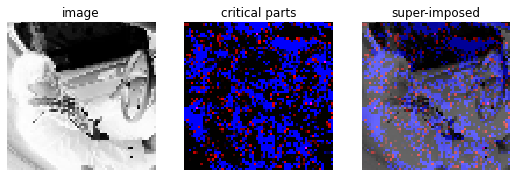

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.4542; nObs: 1
  img_47457.jpg:
  plot_occlusion:


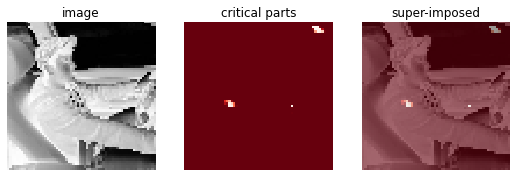

  display_weight:


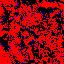

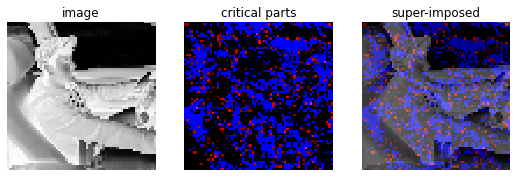

  Proba:
[ 0.      0.2745  0.      0.      0.      0.      0.2713  0.      0.4542
  0.    ]
  next best class: texting - right


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 3277
  img_100059.jpg:
  plot_occlusion:


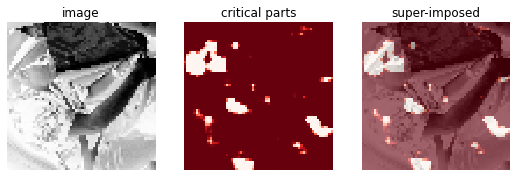

  display_weight:


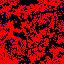

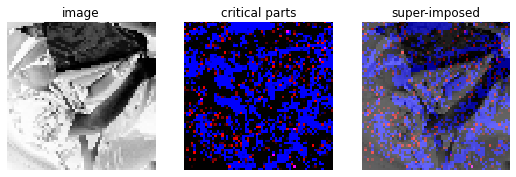

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.4916; nObs: 1
  img_60087.jpg:
  plot_occlusion:


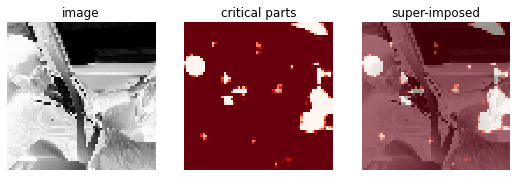

  display_weight:


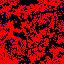

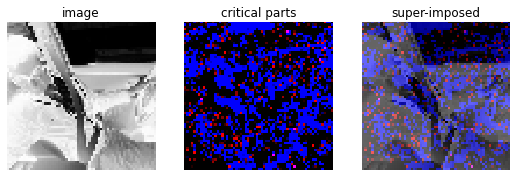

  Proba:
[ 0.      0.      0.      0.4787  0.0297  0.      0.      0.      0.
  0.4916]
  next best class: texting - left

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 5912,  6862, 13313,  5473,  6331,  5926,  6398, 11066, 13115,  5330]))}
  duration: 605 seconds


In [17]:
selMdlDf, selYVldPby, selYNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = glbXFit.shape[0], 
    nStepsTfw = selMdlSrs['nStepsTfw'][0], 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
    visualize = True, newObs = True, verbose = True)

In [18]:
print '\n selMdl:'
glbwriteSubmission(glbINew, selYNewPby, 
    'img_03_fit_lgtRgr_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_sel.csv')


 selMdl:
                           img            c0   c1            c2        c3  \
img                                                                         
img_1.jpg            img_1.jpg  0.000000e+00  0.0  1.000000e+00  0.000000   
img_10.jpg          img_10.jpg  1.427912e-35  0.0  0.000000e+00  0.999995   
img_100.jpg        img_100.jpg  1.000000e+00  0.0  0.000000e+00  0.000000   
img_1000.jpg      img_1000.jpg  2.169752e-02  0.0  4.223761e-28  0.000000   
img_100000.jpg  img_100000.jpg  1.572388e-29  0.0  0.000000e+00  0.000206   

                          c4            c5            c6            c7  \
img                                                                      
img_1.jpg       6.472355e-27  0.000000e+00  7.426608e-16  3.053977e-13   
img_10.jpg      0.000000e+00  4.504863e-06  0.000000e+00  0.000000e+00   
img_100.jpg     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
img_1000.jpg    5.359199e-17  0.000000e+00  9.462698e-01  0.000000e+00   
img_10

### Fit selected model to glbObsTrn


Logistic Regression (TensorFlow): nObsFit:22424; nStepsTfw: 1000; lrnRateTfw:10.0000
  visualize: True; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized
  logLoss at step   200: 80.1486 (132 secs)
  logLoss at step   400: 1.7235 (256 secs)
  logLoss at step   600: 0.8414 (383 secs)
  logLoss at step   800: 0.4962 (511 secs)

  Fit accuracy:0.9860
  Fit  logLoss:0.1987

  Vld accuracy:0.9873
[ 0.9897  0.9916  0.9934  0.9955  0.9869  0.9787  0.9819  0.9886  0.978
  0.9867]
[[479   0   1   1   1   0   1   0   1   0]
 [  0 474   0   0   0   0   0   0   4   0]
 [  0   1 449   0   0   0   0   0   2   0]
 [  0   0   1 441   0   1   0   0   0   0]
 [  1   0   1   1 453   1   0   0   2   0]
 [  3   0   3   0   2 413   0   0   1   0]
 [  1   2   0   0   1   0 435   0   4   0]
 [  0   0   1   0   0   0   3 346   0   0]
 [  1   1   1   1   0   0   0   1 356   3]
 [  1   

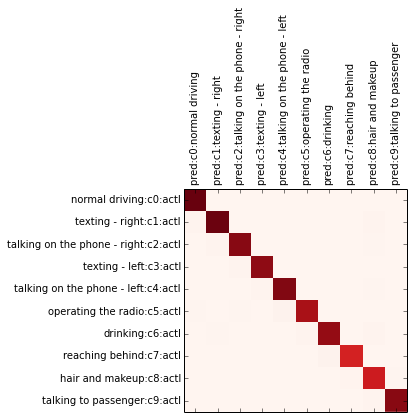


  Vld  logLoss:0.1931
[ 0.0123  0.0242  0.0177  0.006   0.0157  0.0469  0.0126  0.0176  0.0281
  0.012 ]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 456
  img_62023.jpg:
  plot_occlusion:


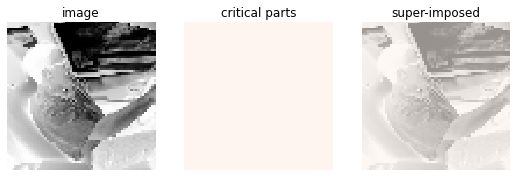

  display_weight:


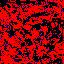

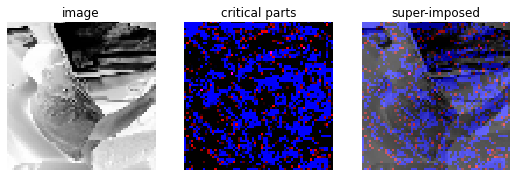

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.5354; nObs: 1
  img_18149.jpg:
  plot_occlusion:


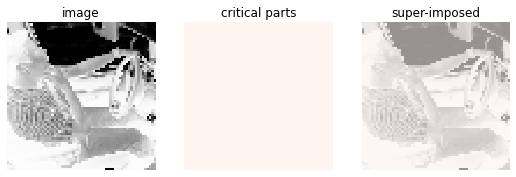

  display_weight:


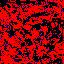

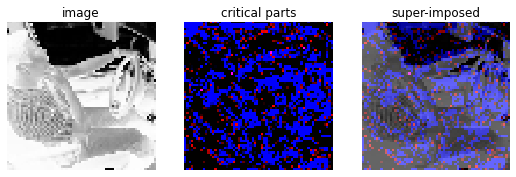

  Proba:
[ 0.5354  0.      0.      0.      0.      0.      0.      0.      0.4646
  0.    ]
  next best class: hair and makeup


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 467
  img_89322.jpg:
  plot_occlusion:


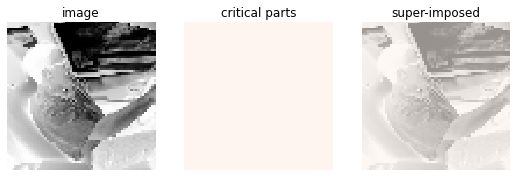

  display_weight:


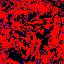

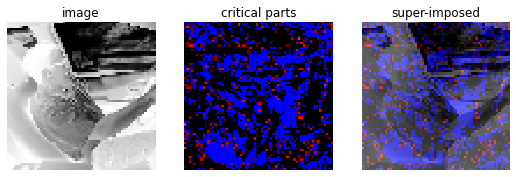

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.7596; nObs: 1
  img_73652.jpg:
  plot_occlusion:


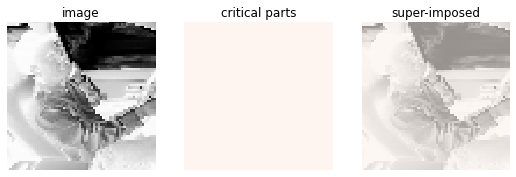

  display_weight:


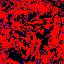

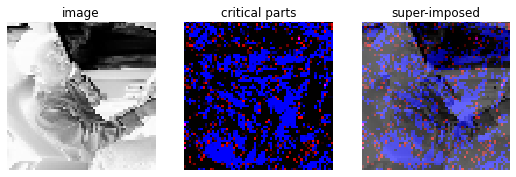

  Proba:
[ 0.      0.7596  0.      0.      0.      0.      0.2404  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 436
  img_29251.jpg:
  plot_occlusion:


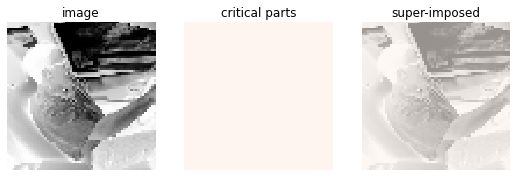

  display_weight:


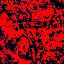

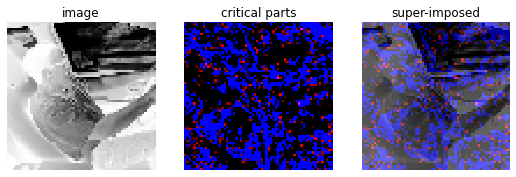

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5330; nObs: 1
  img_4967.jpg:
  plot_occlusion:


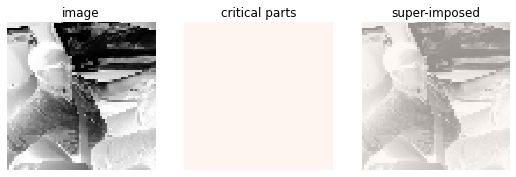

  display_weight:


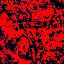

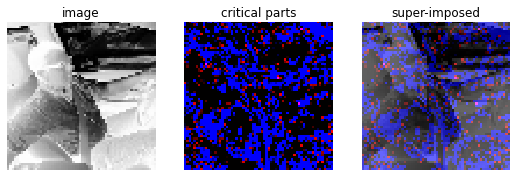

  Proba:
[ 0.      0.      0.533   0.      0.4669  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 420
  img_77361.jpg:
  plot_occlusion:


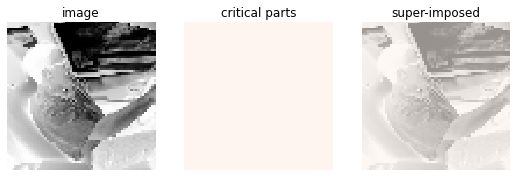

  display_weight:


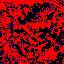

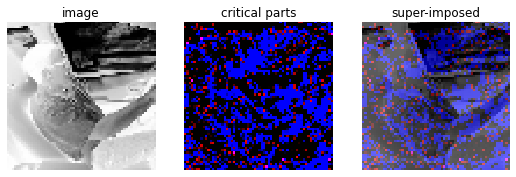

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.6106; nObs: 1
  img_39039.jpg:
  plot_occlusion:


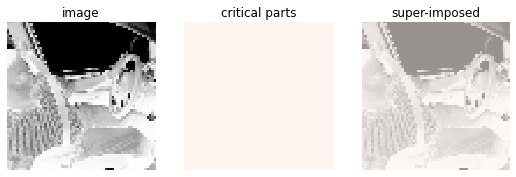

  display_weight:


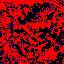

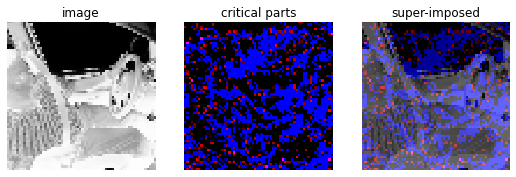

  Proba:
[ 0.      0.      0.      0.6106  0.      0.      0.      0.      0.3891
  0.0003]
  next best class: hair and makeup


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 437
  img_79904.jpg:
  plot_occlusion:


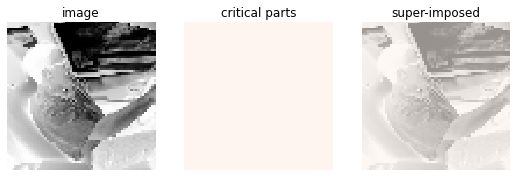

  display_weight:


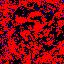

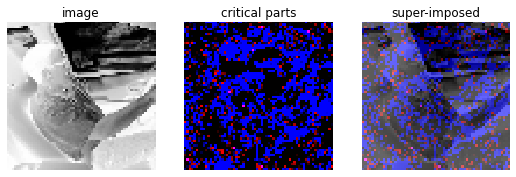

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.7069; nObs: 1
  img_61406.jpg:
  plot_occlusion:


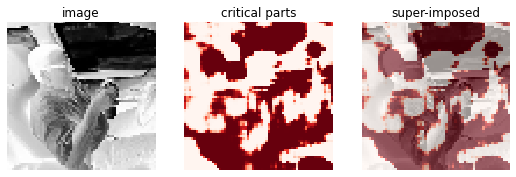

  display_weight:


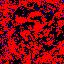

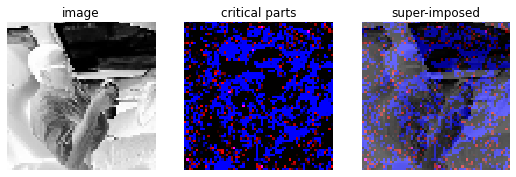

  Proba:
[ 0.      0.      0.      0.0847  0.7069  0.      0.      0.2084  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 400
  img_70461.jpg:
  plot_occlusion:


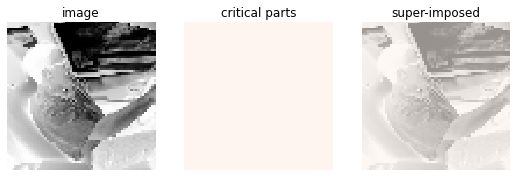

  display_weight:


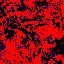

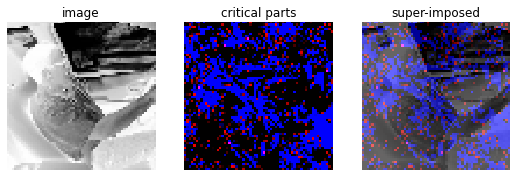

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5448; nObs: 1
  img_94334.jpg:
  plot_occlusion:


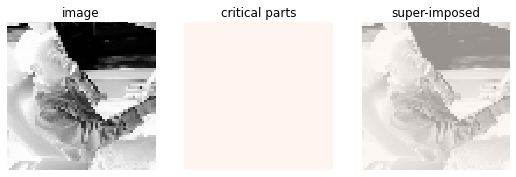

  display_weight:


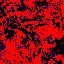

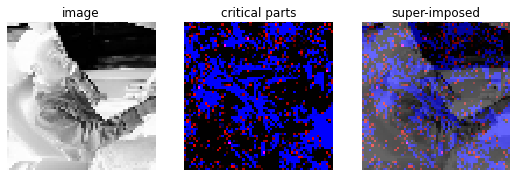

  Proba:
[ 0.      0.      0.      0.      0.      0.5448  0.4327  0.0225  0.      0.    ]
  next best class: drinking


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 414
  img_68722.jpg:
  plot_occlusion:


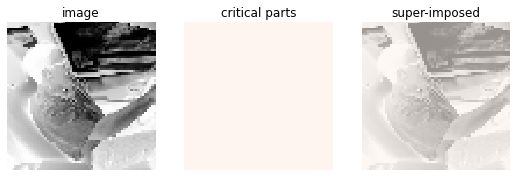

  display_weight:


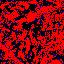

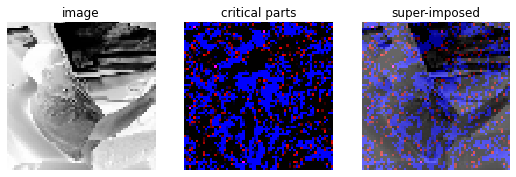

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.6801; nObs: 1
  img_25077.jpg:
  plot_occlusion:


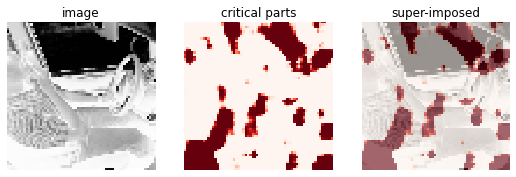

  display_weight:


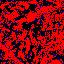

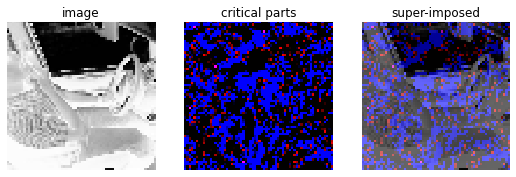

  Proba:
[ 0.      0.      0.      0.      0.3199  0.      0.6801  0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 340
  img_94744.jpg:
  plot_occlusion:


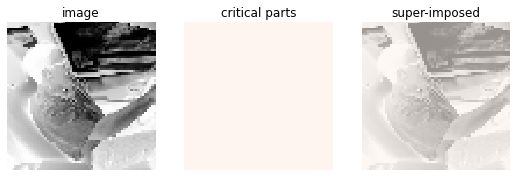

  display_weight:


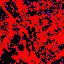

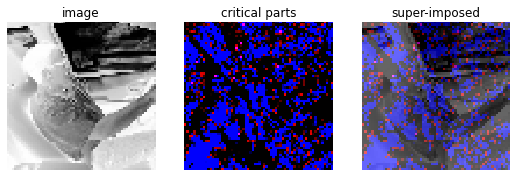

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.7922; nObs: 1
  img_31899.jpg:
  plot_occlusion:


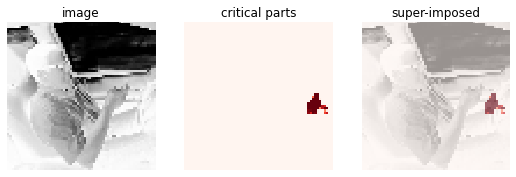

  display_weight:


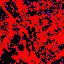

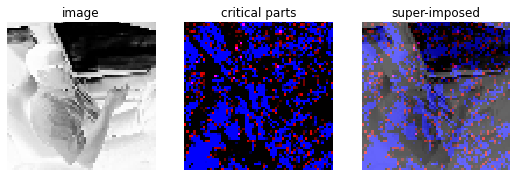

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.      0.7922  0.2078
  0.    ]
  next best class: hair and makeup


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 341
  img_78749.jpg:
  plot_occlusion:


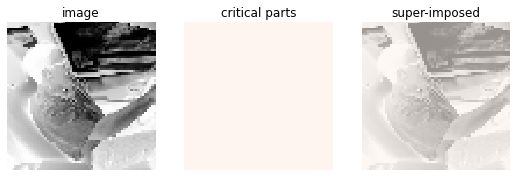

  display_weight:


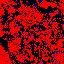

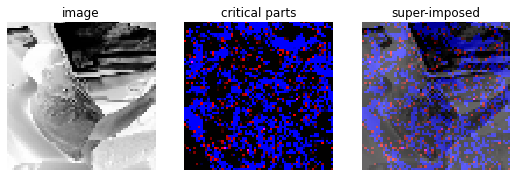

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.6049; nObs: 1
  img_41698.jpg:
  plot_occlusion:


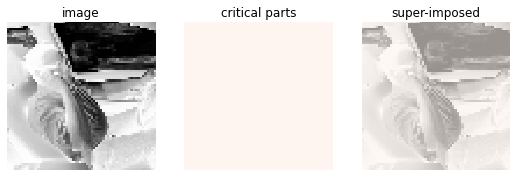

  display_weight:


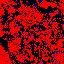

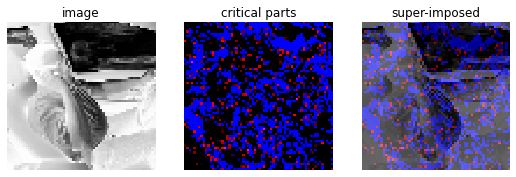

  Proba:
[ 0.      0.      0.0236  0.      0.0025  0.      0.      0.      0.6049
  0.3689]
  next best class: talking to passenger


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 431
  img_24934.jpg:
  plot_occlusion:


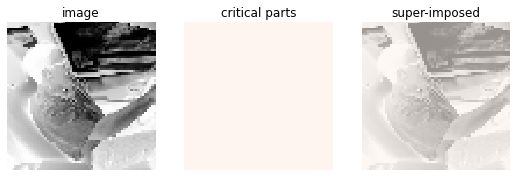

  display_weight:


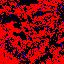

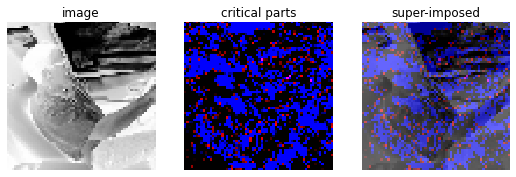

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.5018; nObs: 1
  img_56078.jpg:
  plot_occlusion:


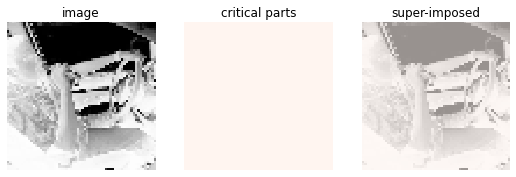

  display_weight:


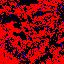

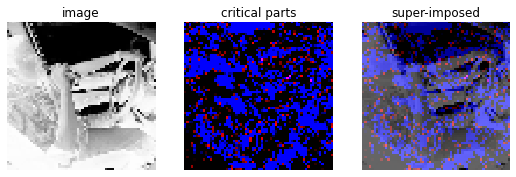

  Proba:
[ 0.      0.      0.      0.4982  0.      0.      0.      0.      0.
  0.5018]
  next best class: texting - left
  predicting 79726 new obs...
    @  685 secs: obsIx:     0
    @  686 secs: obsIx:  8000
    @  692 secs: obsIx: 40000


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 4198
  img_100.jpg:
  plot_occlusion:


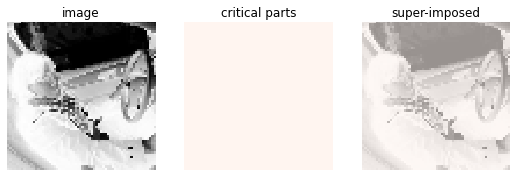

  display_weight:


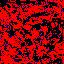

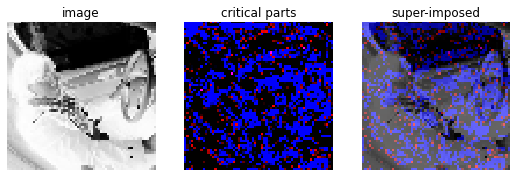

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.4145; nObs: 1
  img_43032.jpg:
  plot_occlusion:


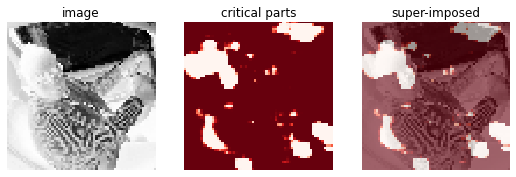

  display_weight:


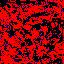

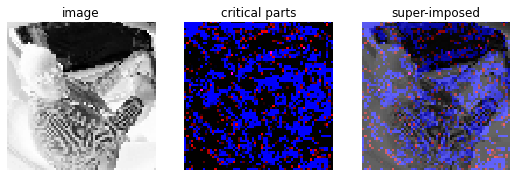

  Proba:
[ 0.4145  0.      0.      0.      0.0101  0.2402  0.      0.      0.
  0.3352]
  next best class: talking to passenger


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 6052
  img_100003.jpg:
  plot_occlusion:


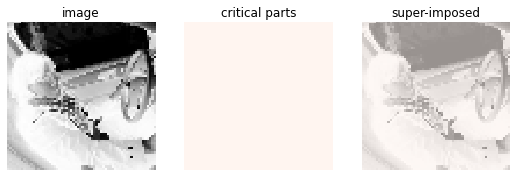

  display_weight:


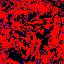

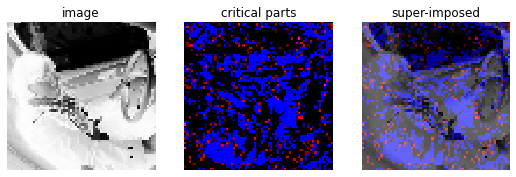

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4720; nObs: 1
  img_12460.jpg:
  plot_occlusion:


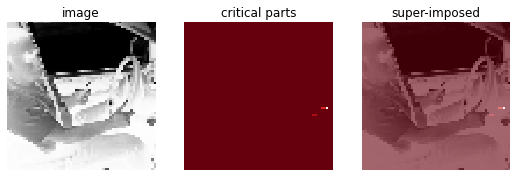

  display_weight:


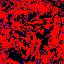

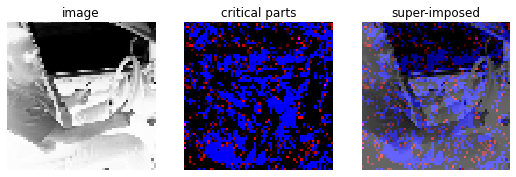

  Proba:
[ 0.      0.472   0.      0.      0.3052  0.      0.      0.      0.2227
  0.    ]
  next best class: talking on the phone - left


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 7429
  img_100004.jpg:
  plot_occlusion:


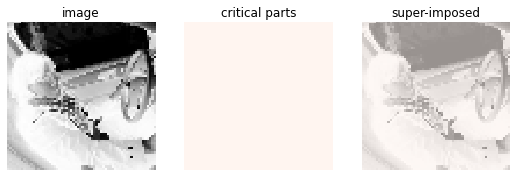

  display_weight:


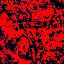

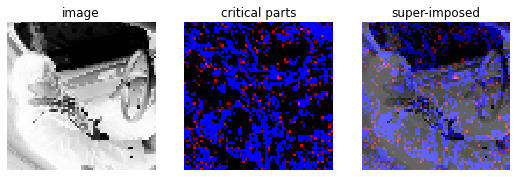

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.3566; nObs: 1
  img_43106.jpg:
  plot_occlusion:


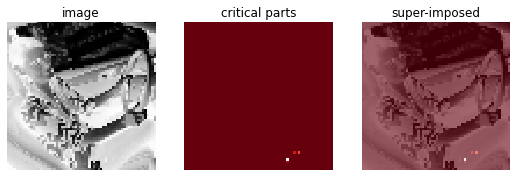

  display_weight:


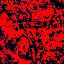

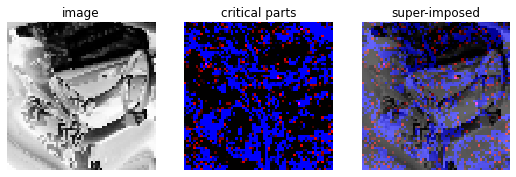

  Proba:
[ 0.      0.      0.3566  0.      0.      0.      0.3504  0.2548  0.0383
  0.    ]
  next best class: drinking


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 4675
  img_10.jpg:
  plot_occlusion:


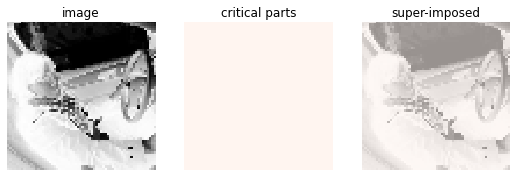

  display_weight:


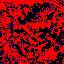

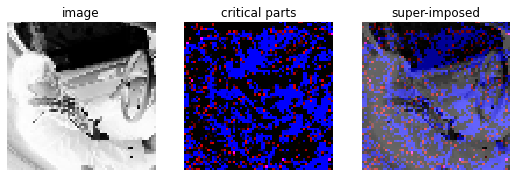

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.4322; nObs: 1
  img_66664.jpg:
  plot_occlusion:


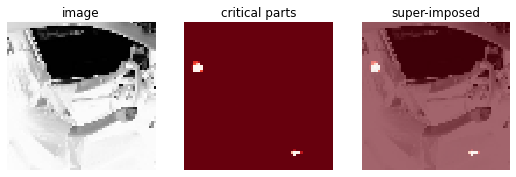

  display_weight:


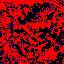

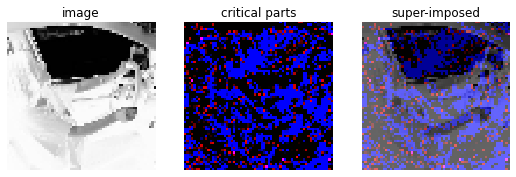

  Proba:
[ 0.      0.      0.      0.4322  0.2481  0.      0.      0.      0.3193
  0.0005]
  next best class: hair and makeup


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 3906
  img_100000.jpg:
  plot_occlusion:


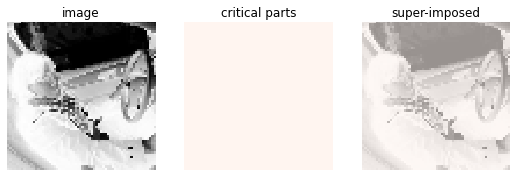

  display_weight:


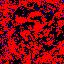

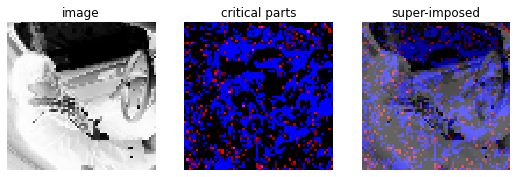

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.4757; nObs: 1
  img_39147.jpg:
  plot_occlusion:


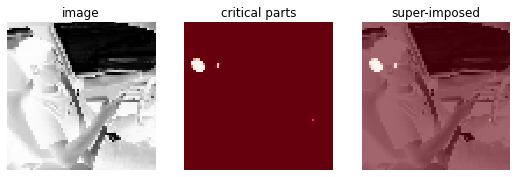

  display_weight:


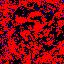

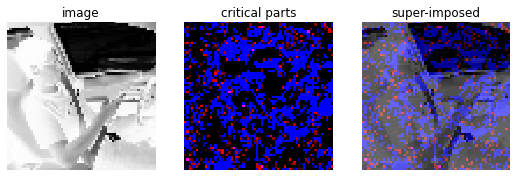

  Proba:
[ 0.      0.4613  0.      0.      0.4757  0.      0.063   0.      0.      0.    ]
  next best class: texting - right


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 5933
  img_100001.jpg:
  plot_occlusion:


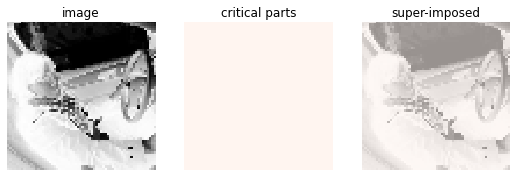

  display_weight:


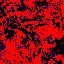

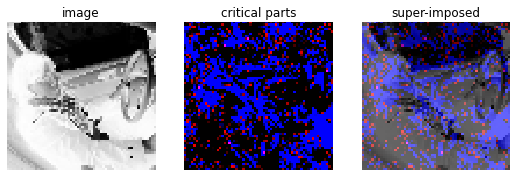

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.4604; nObs: 1
  img_80713.jpg:
  plot_occlusion:


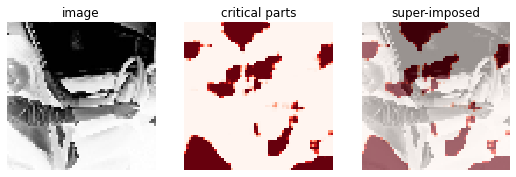

  display_weight:


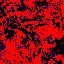

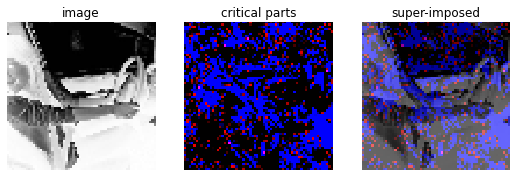

  Proba:
[ 0.0368  0.3452  0.      0.      0.      0.4604  0.1576  0.      0.      0.    ]
  next best class: texting - right


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 3421
  img_100012.jpg:
  plot_occlusion:


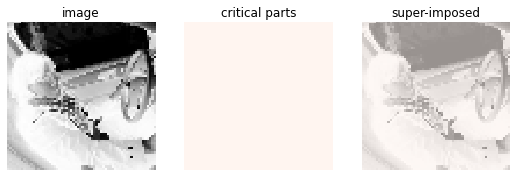

  display_weight:


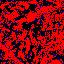

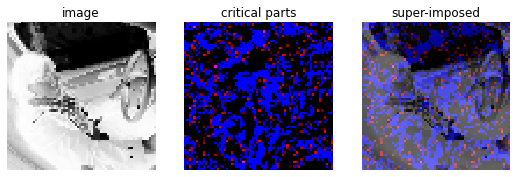

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.3870; nObs: 1
  img_54298.jpg:
  plot_occlusion:


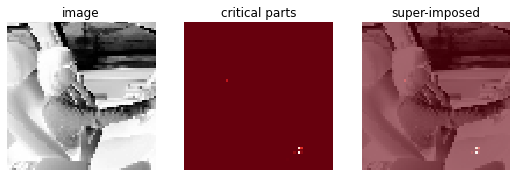

  display_weight:


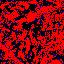

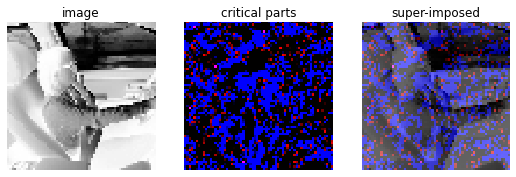

  Proba:
[ 0.      0.212   0.      0.      0.      0.      0.387   0.024   0.
  0.3769]
  next best class: talking to passenger


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 5613
  img_1.jpg:
  plot_occlusion:


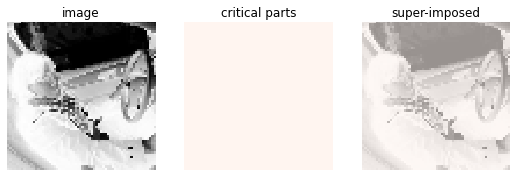

  display_weight:


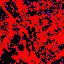

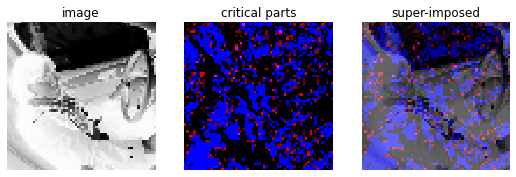

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4808; nObs: 1
  img_46770.jpg:
  plot_occlusion:


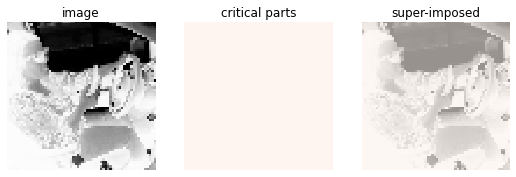

  display_weight:


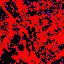

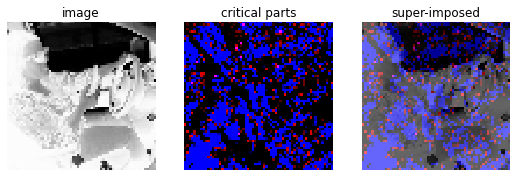

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.      0.4808  0.245
  0.2741]
  next best class: talking to passenger


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 11917
  img_100007.jpg:
  plot_occlusion:


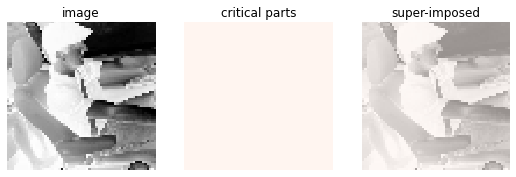

  display_weight:


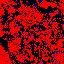

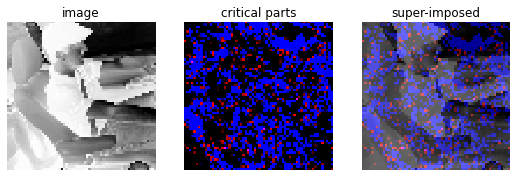

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.4189; nObs: 1
  img_58521.jpg:
  plot_occlusion:


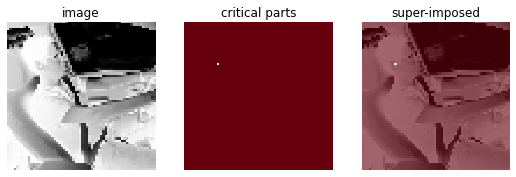

  display_weight:


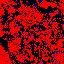

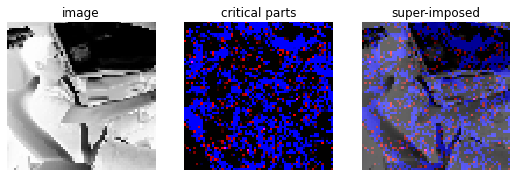

  Proba:
[ 0.      0.0475  0.3864  0.      0.      0.      0.      0.      0.4189
  0.1472]
  next best class: talking on the phone - right


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 5113
  img_100031.jpg:
  plot_occlusion:


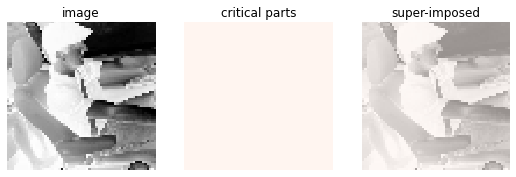

  display_weight:


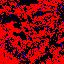

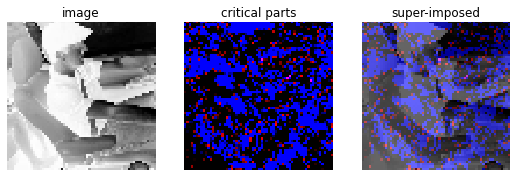

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.3990; nObs: 1
  img_26146.jpg:
  plot_occlusion:


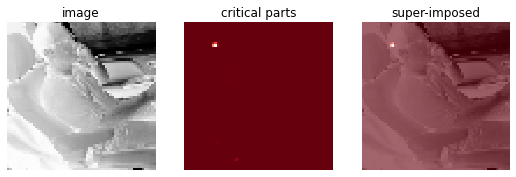

  display_weight:


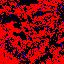

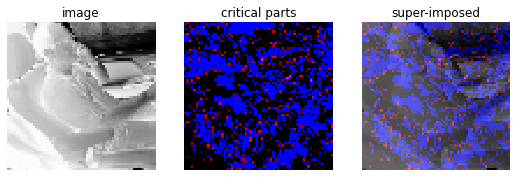

  Proba:
[ 0.     0.     0.     0.     0.     0.235  0.366  0.     0.     0.399]
  next best class: drinking

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 6095,  8375, 10224,  6206,  5471,  7402,  5010,  7377, 16108,  7458]))}
  duration: 743 seconds


In [16]:
finMdlDf, finYVldPby, finYNewPby = fitMdlLgtRgrTfw(
    glbXTrn, glbYTrn, 
    nObsFit = glbXTrn.shape[0], 
    nStepsTfw = selMdlSrs['nStepsTfw'][0], 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
    visualize = True, newObs = True, verbose = True)

# finMdlDf, glbYNewPredProba = fitMdlLgtRgrTfw(glbXTrn, glbYTrn, 
#                         nObsFit = glbXTrn.shape[0], 
#                         nStepsTfw = selMdlSrs['nStepsTfw'][0], 
#                      verbose = True)

In [17]:
print finMdlDf

           id  lrnRateTfw  nObsFit  nStepsTfw    accVld  \
0  LgtRgr.tfw        10.0    22424     1000.0  0.987348   

                                           accVldCls  logLossVld  \
0  {u'accCls': [0.989669421488, 0.991631799163, 0...    0.193149   

                                       logLossVldCls  \
0  {u'logLossCls': [0.0123335882818, 0.0241534716...   

                                             predNew  \
0  {u'kntCls': ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [...   

                                               model  duration  
0  <tensorflow.python.client.session.Session obje...       743  


In [18]:
glbMdlDf = glbMdlDf.append(finMdlDf)
glbMdlDf = glbMdlDf.set_index(['id'] + srchParamsDct.keys(), drop = False)
glbMdlDf = glbMdlDf.sort_values(
                ['nObsFit', 'accVld', 'logLossVld', 'duration'], 
    ascending = [False    , True    , False,        False])
print(glbMdlDf[list(set(glbMdlDf.columns) - 
                    set(['id'] + srchParamsDct.keys()))])

                                                                                 accVldCls  \
id         nStepsTfw nObsFit lrnRateTfw                                                      
LgtRgr.tfw  1000.0   22424.0  10.0       {u'accCls': [0.989669421488, 0.991631799163, 0...   
LgtRgr.skl -1.0      22424.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  1.0        {u'accCls': [0.326446280992, 0.209205020921, 0...   
LgtRgr.skl -1.0      18077.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   18077.0  10.0       {u'accCls': [0.504132231405, 0.435146443515, 0...   
LgtRgr.skl -1.0      15000.0 -1.0                                                      NaN   
LgtRgr.tfw  1000.0   10000.0  0.1        {u'accCls': [0.169421487603, 0.144351464435, 0...   
                              1.0        {u'accCls': [0.289256198347, 0.182008368201, 0...   
LgtRgr.skl -1.0      10000.0 -1.0                           

In [19]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 6 KB


## Output submission

In [20]:
print '\n finMdl:'
glbwriteSubmission(glbINew, finYNewPby, 
    'img_03_fit_lgtRgr_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_fin.csv')


 finMdl:
                           img            c0   c1            c2            c3  \
img                                                                             
img_1.jpg            img_1.jpg  0.000000e+00  0.0  4.523997e-22  0.000000e+00   
img_10.jpg          img_10.jpg  0.000000e+00  0.0  0.000000e+00  1.000000e+00   
img_100.jpg        img_100.jpg  1.000000e+00  0.0  0.000000e+00  6.839675e-24   
img_1000.jpg      img_1000.jpg  3.653086e-23  0.0  2.392649e-37  0.000000e+00   
img_100000.jpg  img_100000.jpg  0.000000e+00  0.0  0.000000e+00  2.044043e-26   

                          c4   c5        c6   c7            c8            c9  
img                                                                           
img_1.jpg       3.088292e-35  0.0  0.000000  1.0  0.000000e+00  0.000000e+00  
img_10.jpg      0.000000e+00  0.0  0.000000  0.0  0.000000e+00  0.000000e+00  
img_100.jpg     0.000000e+00  0.0  0.000000  0.0  0.000000e+00  2.938211e-22  
img_1000.jpg    1.649245e-1

In [24]:
prtStr = 'LeaderBoard metric for this sel submission: %0.5f vs. ' + \
        'logLossVld (sel): %0.5f'
print prtStr % (20.00136, 19.2099)
prtStr = 'LeaderBoard metric for this fin submission: %0.5f vs. ' + \
        'logLossVld (fin): %0.5f'
print prtStr % (18.99503, 0.193149)
print 'Best score yet:%s: %0.5f' % \
    ('img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv', 2.63892)

LeaderBoard metric for this sel submission: 20.00136 vs. logLossVld (sel): 19.20990
LeaderBoard metric for this fin submission: 18.99503 vs. logLossVld (fin): 0.19315
Best score yet:img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv: 2.63892


## Stop here

Following code should be in img_04_fit_lgtRgrSGDTf_<projectId>

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [6]:
import pandas as pd
models = pd.DataFrame({'nRELUs': [0]})
#models.ix[0, 'accuracy_scoreTest'] = 0
print models

   nRELUs
0       0


In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]))
  tfwB = tf.Variable(tf.zeros([glbRspClassN]))
  print(tfwW.initialized_value())
  print(tfwB.initialized_value())    
  
  # Training computation.
  logits = tf.matmul(tfwObsFitFtr, tfwW) + tfwB
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(logits)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tfwObsVldFtr, tfwW) + tfwB)
  tfwObsNewPred = tf.nn.softmax(tf.matmul(tfwObsNewFtr, tfwW) + tfwB)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run it:

In [8]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[0, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[0, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)

Initialized
Minibatch loss at step 0: 17.272371
Minibatch accuracy: 6.2%
Validation accuracy: 13.0%
Minibatch loss at step 500: 1.435902
Minibatch accuracy: 76.6%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.280029
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 1.147653
Minibatch accuracy: 77.3%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 1.262677
Minibatch accuracy: 72.7%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 0.777248
Minibatch accuracy: 83.6%
Validation accuracy: 77.3%
Minibatch loss at step 3000: 1.085464
Minibatch accuracy: 77.3%
Validation accuracy: 78.6%
Test accuracy: 86.1%


In [9]:
models.ix[0, 'graph'] = graph
print(models)

   nRELUs  accuracyVld  accuracyTst  \
0       0        78.57    86.098056   

                                               graph  
0  <tensorflow.python.framework.ops.Graph object ...  


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy_score.

---

In [10]:
nRELUs = [2 ** thsRelu for thsRelu in xrange(11)]
print(nRELUs)
for thsRelu in nRELUs:
    models.ix[thsRelu, 'nRELUs'] = thsRelu

print models

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1          NaN          NaN   
2          2          NaN          NaN   
4          4          NaN          NaN   
8          8          NaN          NaN   
16        16          NaN          NaN   
32        32          NaN          NaN   
64        64          NaN          NaN   
128      128          NaN          NaN   
256      256          NaN          NaN   
512      512          NaN          NaN   
1024    1024          NaN          NaN   

                                                  graph  
0     <tensorflow.python.framework.ops.Graph object ...  
1                                                   NaN  
2                                                   NaN  
4                                                   NaN  
8                                                   NaN  
16                                                  NaN  
3

In [49]:
thsRelu = nRELUs[9]
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW1 = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], thsRelu]), name = 'tfwW1')
  tfwB1 = tf.Variable(tf.zeros([thsRelu]), name = 'tfwB1')
  tfwW2 = tf.Variable(
    tf.truncated_normal([thsRelu, glbRspClassN]), name = 'tfwW2')
  tfwB2 = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB2')
  print(tfwW1.initialized_value())
  print(tfwB1.initialized_value())
  #print(relus.initialized_value())
  print(tfwW2.initialized_value())
  print(tfwB2.initialized_value())
  #tf.Print(relus, [relus])  
     
  # Training computation.
  layer1 = tf.matmul(tfwObsFitFtr, tfwW1) + tfwB1
  layer2 = tf.nn.relu(layer1)
  layer3 = tf.matmul(layer2, tfwW2) + tfwB2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(layer3, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(layer3)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsVldFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)
  tfwObsNewPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsNewFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(512)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(512)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(512), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)


In [50]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[thsRelu, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[thsRelu, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)
  models.ix[thsRelu, 'graph'] = graph
  print(models)

Initialized
Minibatch loss at step 0: 235.251495
Minibatch accuracy: 14.1%
Validation accuracy: 23.9%
Minibatch loss at step 500: 15.635325
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 5.719280
Minibatch accuracy: 83.6%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 3.931793
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 3.211185
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 1.988469
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 3.435107
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Test accuracy: 86.7%
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1        19.29    19.750053   
2          2        36.26    40.087588   
4          4        64.67    71.122623   
8          8        75.80    82.861568   
16        16        79.74    86.685537   
32        32        76.77    84.28754

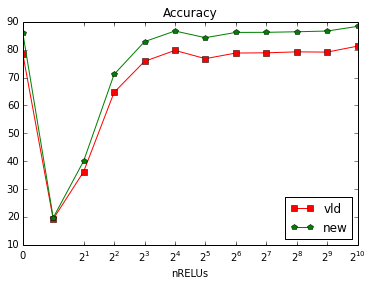

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy_score.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracy_scoreVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracy_scoreTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("accuracy_score")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()